In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchdiffeq import odeint_adjoint as odeint
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
def norm(dim):
    return nn.GroupNorm(min(32, dim), dim)
rtol = 1e-3
atol = 1e-3

In [3]:
class ConcatConv2d(nn.Module):

    def __init__(self, dim_in, dim_out, ksize=3, stride=1, padding=0, dilation=1, groups=1, bias=True, transpose=False):
        super(ConcatConv2d, self).__init__()
        module = nn.ConvTranspose2d if transpose else nn.Conv2d
        self._layer = module(
            dim_in + 1, dim_out, kernel_size=ksize, stride=stride, padding=padding, dilation=dilation, groups=groups,
            bias=bias
        )

    def forward(self, t, x):
        tt = torch.ones_like(x[:, :1, :, :]) * t
        ttx = torch.cat([tt, x], 1)
        return self._layer(ttx)

class ODEfunc(nn.Module):

    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm1 = norm(dim)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm2 = norm(dim)
        self.conv2 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm3 = norm(dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.norm1(x)
        out = self.relu(out)
        out = self.conv1(t, out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(t, out)
        out = self.norm3(out)
        return out


class ODEBlock(nn.Module):

    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time, rtol=rtol, atol=atol)
        return out[1]

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value

class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

In [4]:
downsampling_layers = [
nn.Conv2d(1, 64, 3, 1),
norm(64),
nn.ReLU(inplace=True),
nn.Conv2d(64, 64, 4, 2, 1),
norm(64),
nn.ReLU(inplace=True),
nn.Conv2d(64, 64, 4, 2, 1),
]
feature_layers = [ODEBlock(ODEfunc(64))]
fc_layers = [norm(64), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), Flatten(), nn.Linear(64, 10)]
model = nn.Sequential(
    *downsampling_layers,
    *feature_layers,
    *fc_layers
)

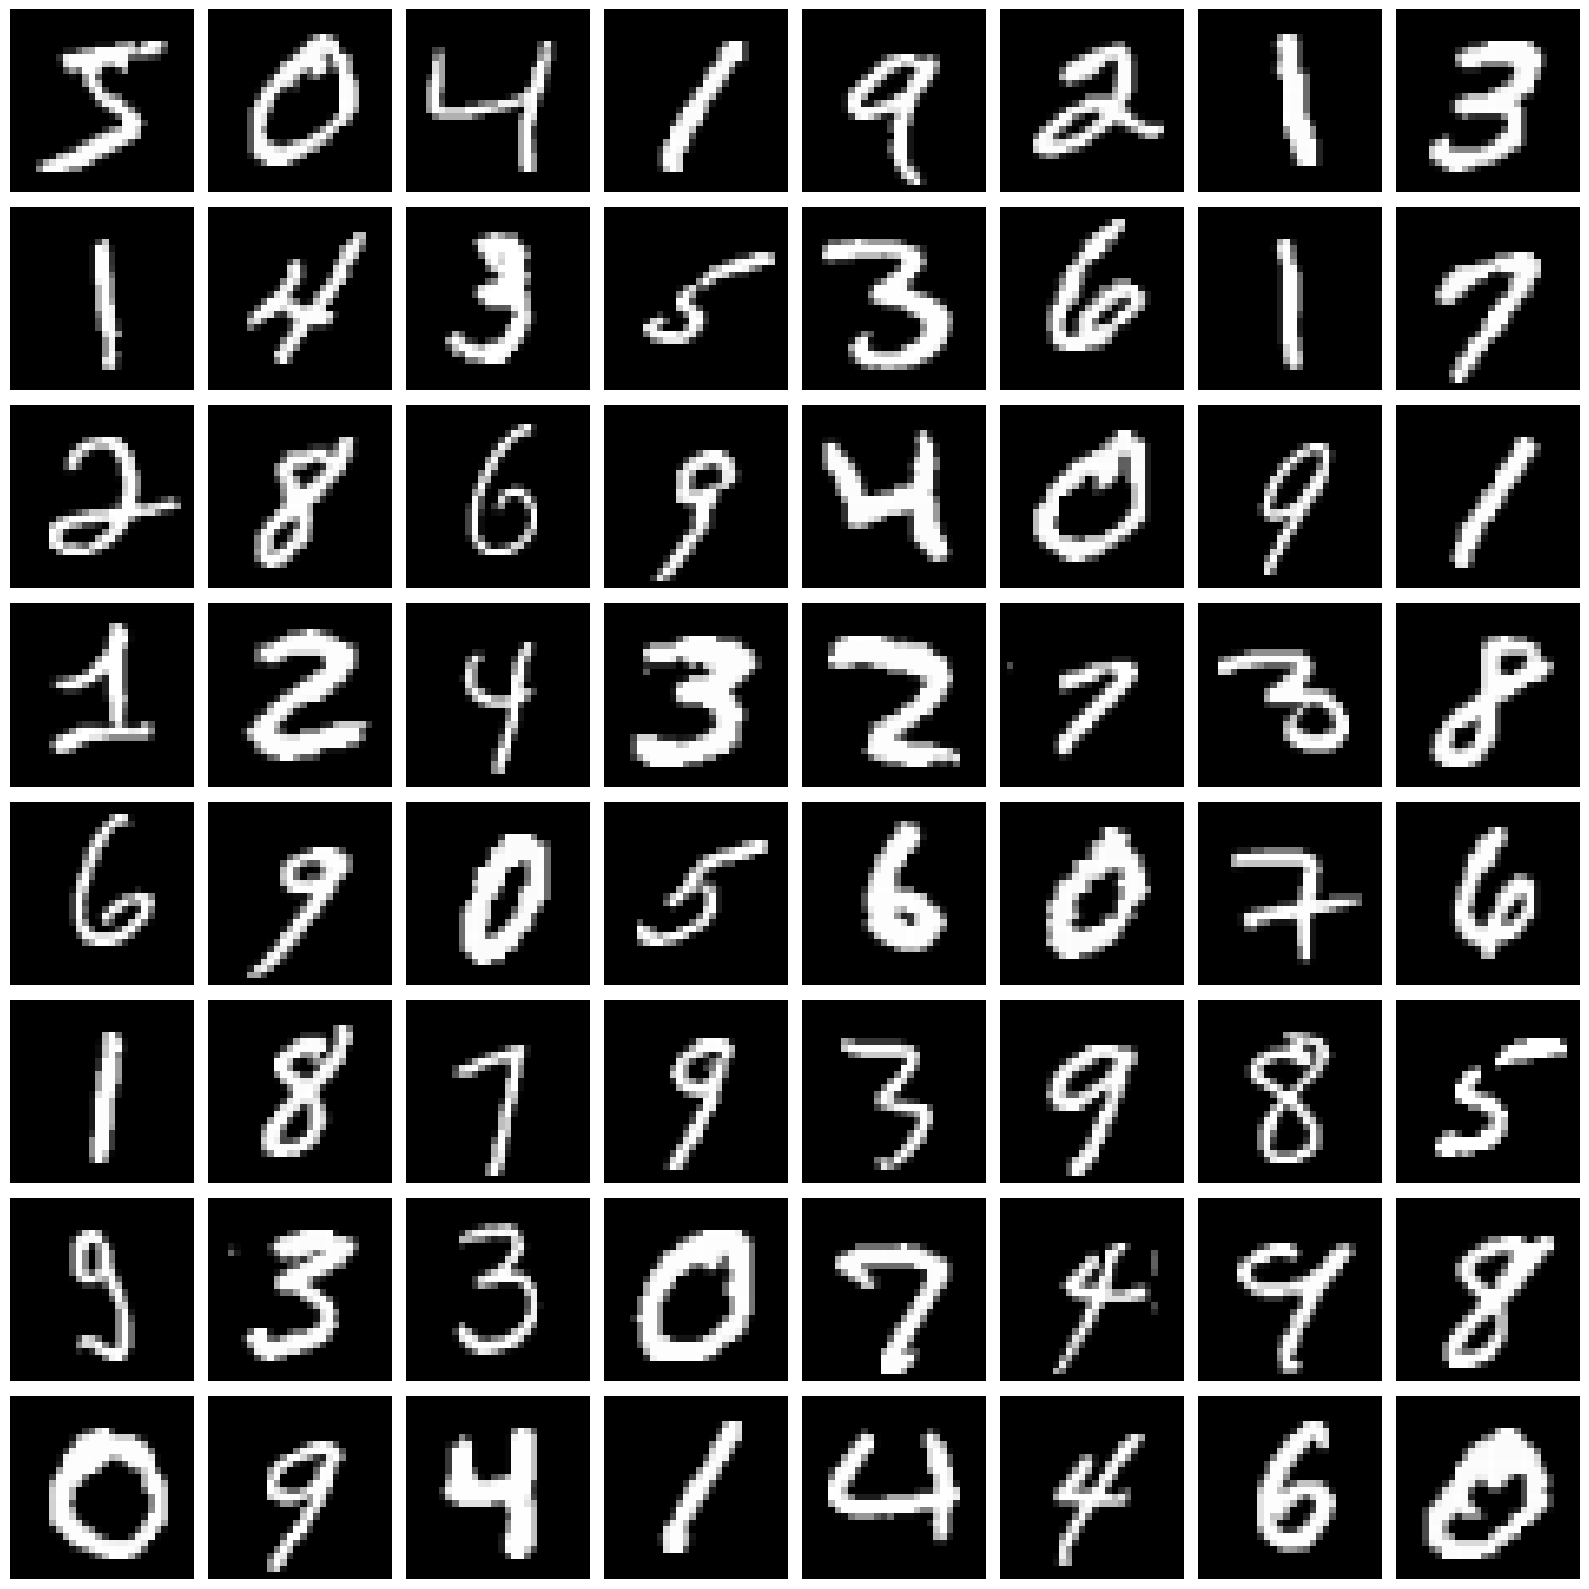

In [ ]:
transform = transforms.Compose([
transforms.RandomCrop(28, padding=4),
transforms.ToTensor(),
NeuralODE_cw.AddGaussianNoise(mean=0.0, std=0.5)
])
mnist = datasets.MNIST(root='./.data/mnist', train=True, transform=transform)
dataloader = DataLoader(mnist, batch_size=64, shuffle=True)
def show_images(images, ncols=8):
    nrows = (len(images) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_images(mnist.data[:64].numpy())



In [59]:
## Load model from experiment folder 

model_state_dict = torch.load('./experiment_implicit_adams/model_0.5_noise.pth',weights_only=False)
model.load_state_dict(model_state_dict['state_dict'])
# Set model to evaluation mode
model.eval()

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): GroupNorm(32, 64, eps=1e-05, affine=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): GroupNorm(32, 64, eps=1e-05, affine=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ODEBlock(
    (odefunc): ODEfunc(
      (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu): ReLU(inplace=True)
      (conv1): ConcatConv2d(
        (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv2): ConcatConv2d(
        (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (norm3): GroupNorm(32, 64, eps=1e-05, affine=True)
    )
  )
  (8): GroupNorm(32, 64, eps=1e-05, affine=True)
  (9): ReLU(inplace=True)
  (10): AdaptiveAvgPool2d(output_size=(1, 1))
  (11): Flatten()


Mismatch for image 0: predicted 8, true label 5


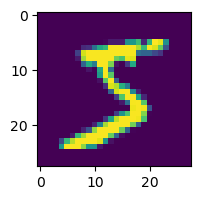

Mismatch for image 1: predicted 8, true label 0


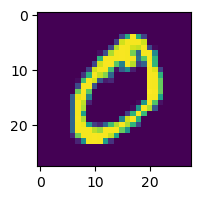

Mismatch for image 2: predicted 8, true label 4


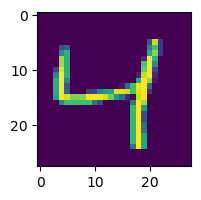

Mismatch for image 3: predicted 8, true label 1


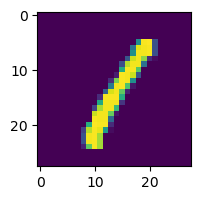

Mismatch for image 4: predicted 8, true label 9


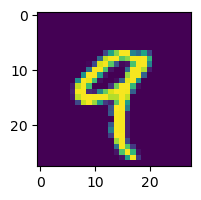

Mismatch for image 5: predicted 8, true label 2


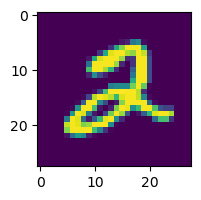

Mismatch for image 6: predicted 8, true label 1


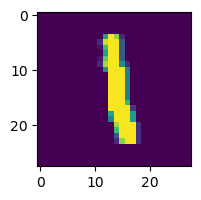

Mismatch for image 7: predicted 8, true label 3


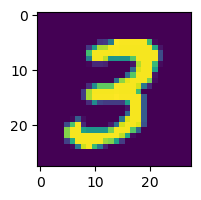

Mismatch for image 8: predicted 8, true label 1


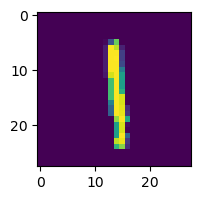

Mismatch for image 9: predicted 8, true label 4


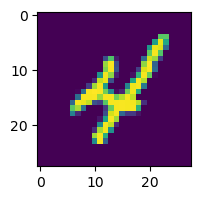

Mismatch for image 10: predicted 8, true label 3


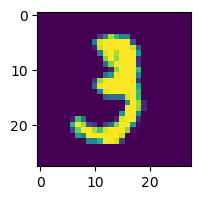

Mismatch for image 11: predicted 8, true label 5


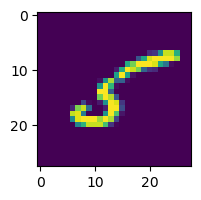

Mismatch for image 12: predicted 8, true label 3


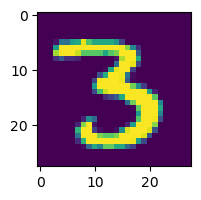

Mismatch for image 13: predicted 8, true label 6


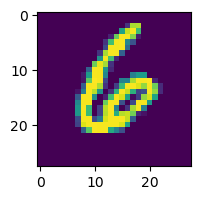

Mismatch for image 14: predicted 8, true label 1


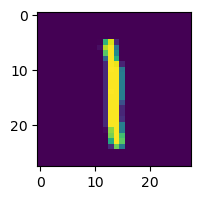

Mismatch for image 15: predicted 8, true label 7


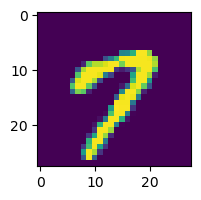

Mismatch for image 16: predicted 8, true label 2


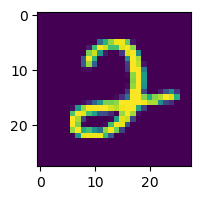

Mismatch for image 18: predicted 8, true label 6


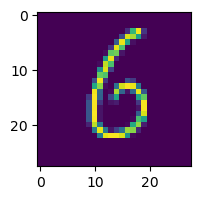

Mismatch for image 19: predicted 8, true label 9


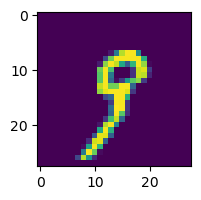

Mismatch for image 20: predicted 8, true label 4


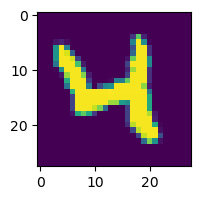

Mismatch for image 21: predicted 8, true label 0


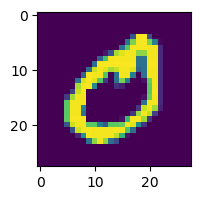

Mismatch for image 22: predicted 8, true label 9


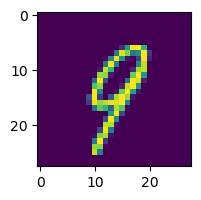

Mismatch for image 23: predicted 8, true label 1


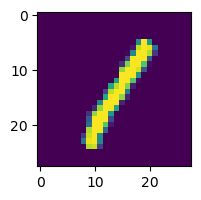

Mismatch for image 24: predicted 8, true label 1


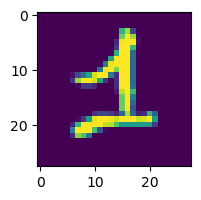

Mismatch for image 25: predicted 8, true label 2


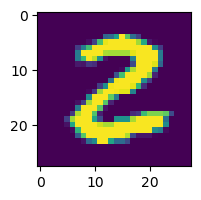

Mismatch for image 26: predicted 8, true label 4


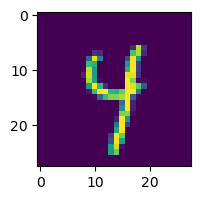

Mismatch for image 27: predicted 8, true label 3


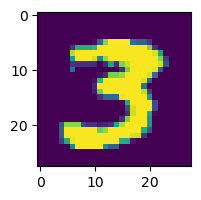

Mismatch for image 28: predicted 8, true label 2


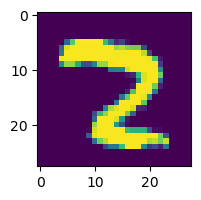

Mismatch for image 29: predicted 8, true label 7


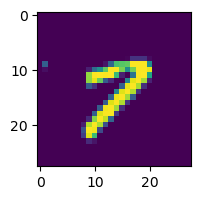

Mismatch for image 30: predicted 8, true label 3


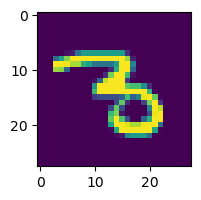

Mismatch for image 32: predicted 8, true label 6


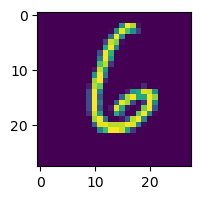

Mismatch for image 33: predicted 8, true label 9


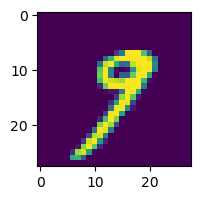

Mismatch for image 34: predicted 8, true label 0


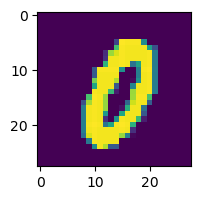

Mismatch for image 35: predicted 8, true label 5


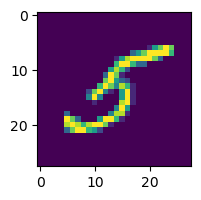

Mismatch for image 36: predicted 8, true label 6


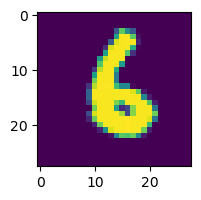

Mismatch for image 37: predicted 8, true label 0


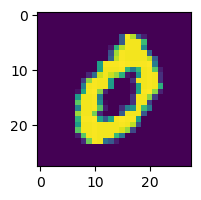

Mismatch for image 38: predicted 8, true label 7


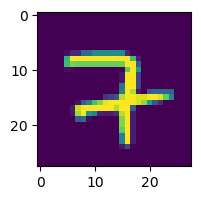

Mismatch for image 39: predicted 8, true label 6


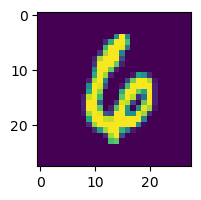

Mismatch for image 40: predicted 8, true label 1


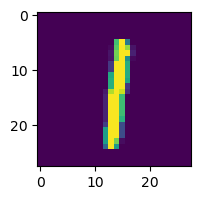

Mismatch for image 42: predicted 8, true label 7


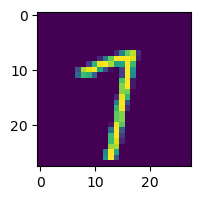

Mismatch for image 43: predicted 8, true label 9


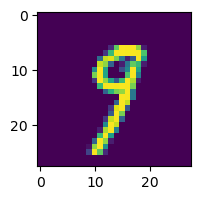

Mismatch for image 44: predicted 8, true label 3


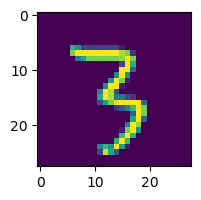

Mismatch for image 45: predicted 8, true label 9


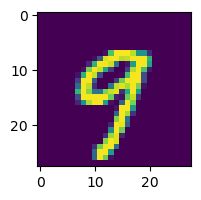

Mismatch for image 47: predicted 8, true label 5


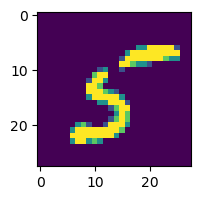

Mismatch for image 48: predicted 8, true label 9


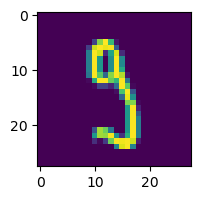

Mismatch for image 49: predicted 8, true label 3


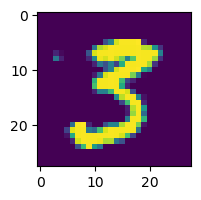

Mismatch for image 50: predicted 8, true label 3


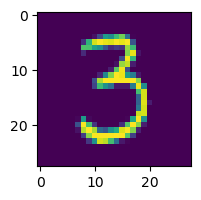

Mismatch for image 51: predicted 8, true label 0


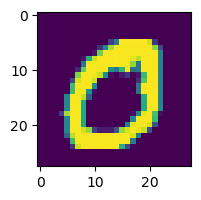

Mismatch for image 52: predicted 8, true label 7


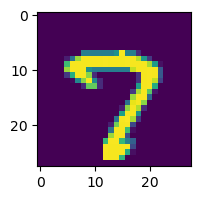

Mismatch for image 53: predicted 8, true label 4


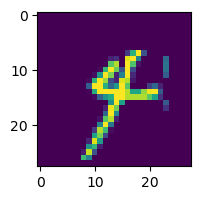

Mismatch for image 54: predicted 8, true label 9


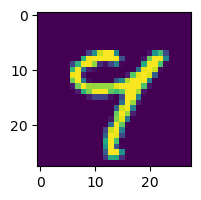

Mismatch for image 56: predicted 8, true label 0


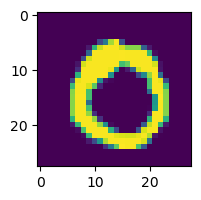

Mismatch for image 57: predicted 8, true label 9


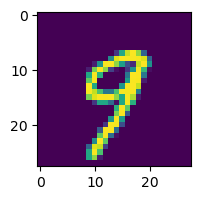

Mismatch for image 58: predicted 8, true label 4


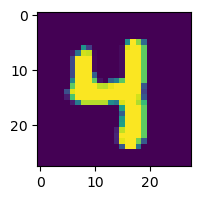

Mismatch for image 59: predicted 8, true label 1


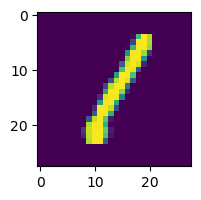

Mismatch for image 60: predicted 8, true label 4


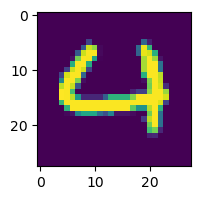

Mismatch for image 61: predicted 8, true label 4


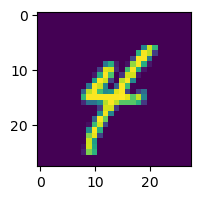

Mismatch for image 62: predicted 8, true label 6


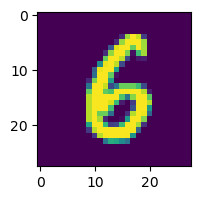

Mismatch for image 63: predicted 8, true label 0


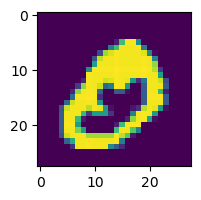

Mismatch for image 64: predicted 8, true label 4


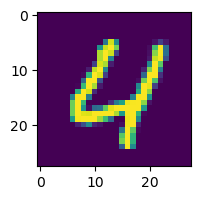

Mismatch for image 65: predicted 8, true label 5


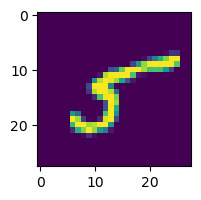

Mismatch for image 66: predicted 8, true label 6


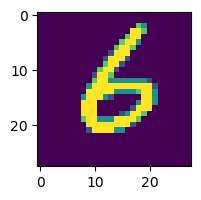

Mismatch for image 67: predicted 8, true label 1


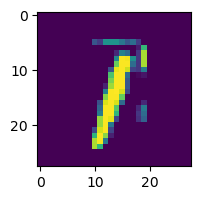

Mismatch for image 68: predicted 8, true label 0


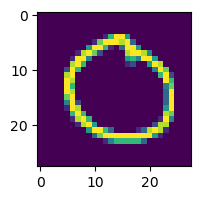

Mismatch for image 69: predicted 8, true label 0


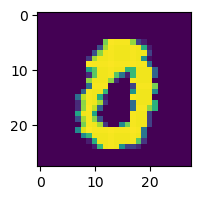

Mismatch for image 70: predicted 8, true label 1


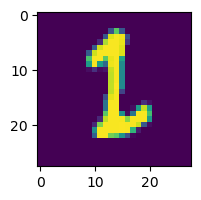

Mismatch for image 71: predicted 8, true label 7


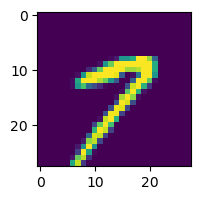

Mismatch for image 72: predicted 8, true label 1


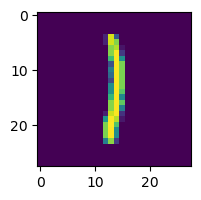

Mismatch for image 73: predicted 8, true label 6


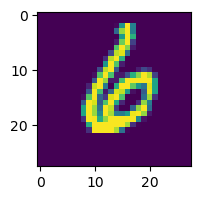

Mismatch for image 74: predicted 8, true label 3


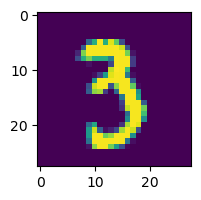

Mismatch for image 75: predicted 8, true label 0


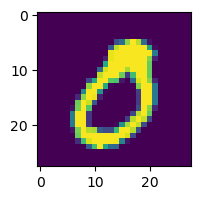

Mismatch for image 76: predicted 8, true label 2


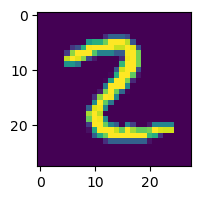

Mismatch for image 77: predicted 8, true label 1


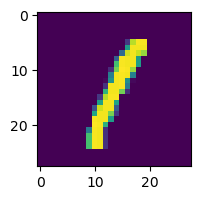

Mismatch for image 78: predicted 8, true label 1


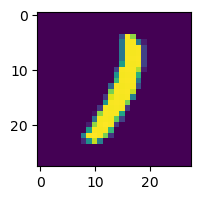

Mismatch for image 79: predicted 8, true label 7


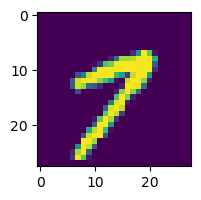

Mismatch for image 80: predicted 8, true label 9


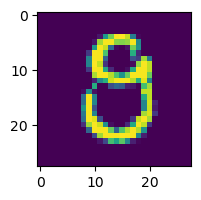

Mismatch for image 81: predicted 8, true label 0


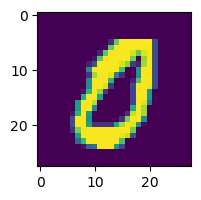

Mismatch for image 82: predicted 8, true label 2


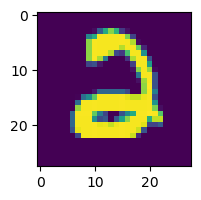

Mismatch for image 83: predicted 8, true label 6


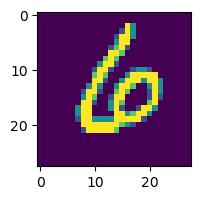

Mismatch for image 84: predicted 8, true label 7


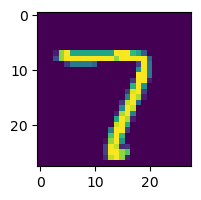

Mismatch for image 86: predicted 8, true label 3


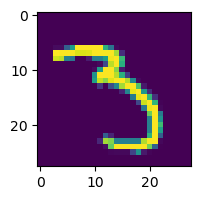

Mismatch for image 87: predicted 8, true label 9


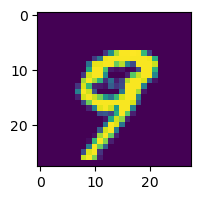

Mismatch for image 88: predicted 8, true label 0


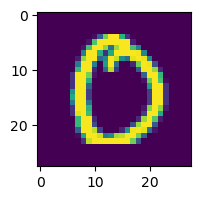

Mismatch for image 89: predicted 8, true label 4


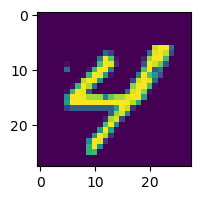

Mismatch for image 90: predicted 8, true label 6


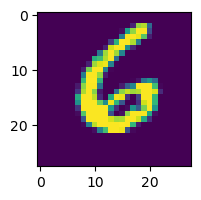

Mismatch for image 91: predicted 8, true label 7


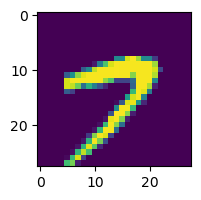

Mismatch for image 92: predicted 8, true label 4


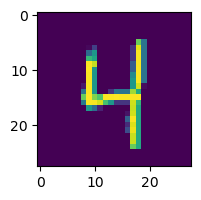

Mismatch for image 93: predicted 8, true label 6


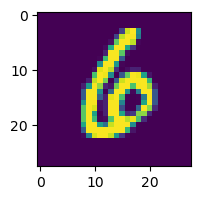

Mismatch for image 95: predicted 8, true label 0


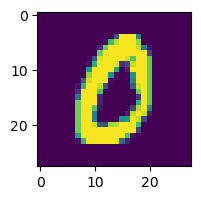

Mismatch for image 96: predicted 8, true label 7


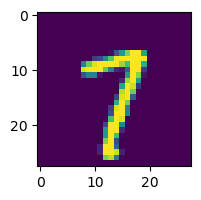

Mismatch for image 98: predicted 8, true label 3


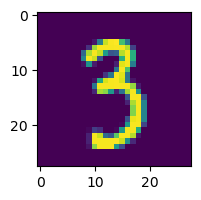

Mismatch for image 99: predicted 8, true label 1


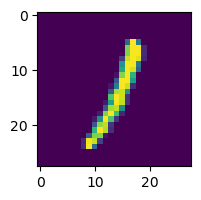

Mismatch for image 100: predicted 8, true label 5


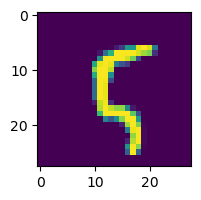

Mismatch for image 101: predicted 8, true label 7


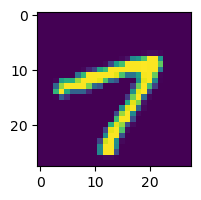

Mismatch for image 102: predicted 8, true label 1


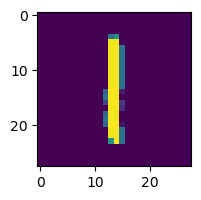

Mismatch for image 103: predicted 8, true label 7


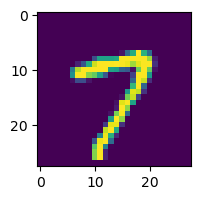

Mismatch for image 104: predicted 8, true label 1


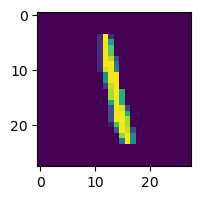

Mismatch for image 105: predicted 8, true label 1


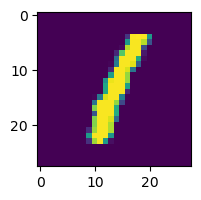

Mismatch for image 106: predicted 8, true label 6


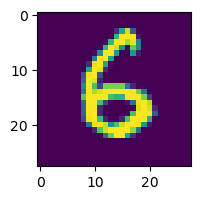

Mismatch for image 107: predicted 8, true label 3


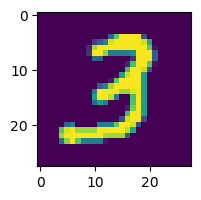

Mismatch for image 108: predicted 8, true label 0


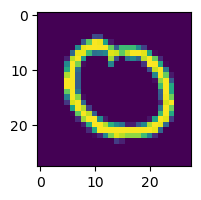

Mismatch for image 109: predicted 8, true label 2


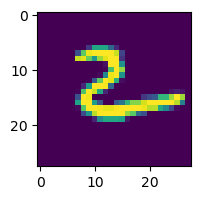

Mismatch for image 110: predicted 8, true label 9


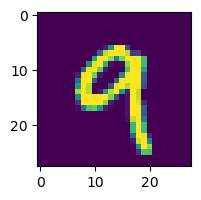

Mismatch for image 111: predicted 8, true label 3


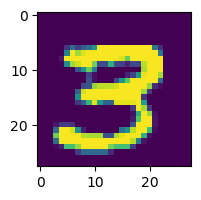

Mismatch for image 112: predicted 8, true label 1


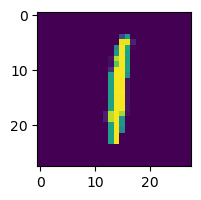

Mismatch for image 113: predicted 8, true label 1


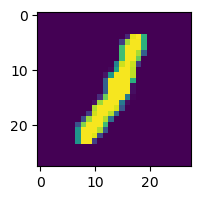

Mismatch for image 114: predicted 8, true label 0


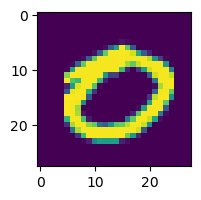

Mismatch for image 115: predicted 8, true label 4


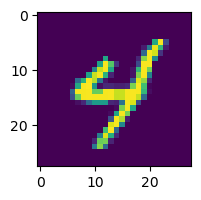

Mismatch for image 116: predicted 8, true label 9


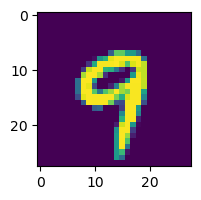

Mismatch for image 117: predicted 8, true label 2


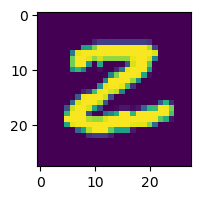

Mismatch for image 118: predicted 8, true label 0


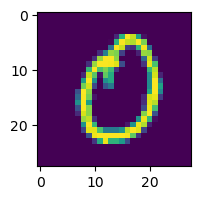

Mismatch for image 119: predicted 8, true label 0


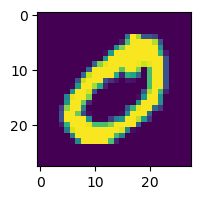

Mismatch for image 120: predicted 8, true label 2


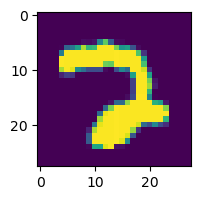

Mismatch for image 121: predicted 8, true label 0


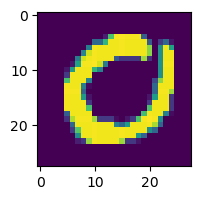

Mismatch for image 122: predicted 8, true label 2


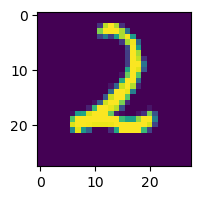

Mismatch for image 123: predicted 8, true label 7


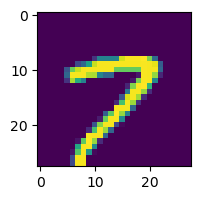

Mismatch for image 124: predicted 8, true label 1


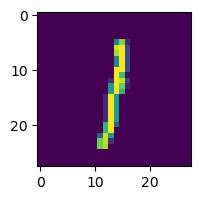

Mismatch for image 126: predicted 8, true label 6


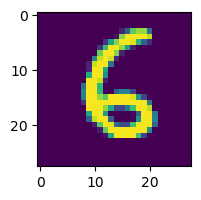

Mismatch for image 127: predicted 8, true label 4


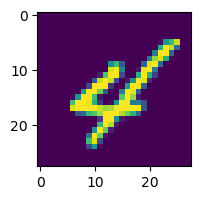

Mismatch for image 128: predicted 8, true label 1


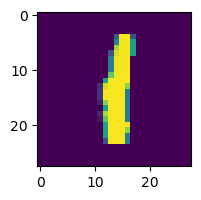

Mismatch for image 129: predicted 8, true label 6


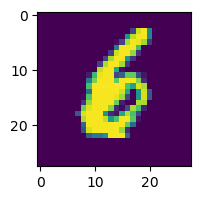

Mismatch for image 130: predicted 8, true label 3


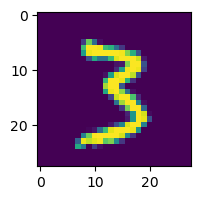

Mismatch for image 131: predicted 8, true label 4


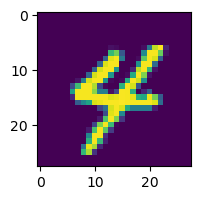

Mismatch for image 132: predicted 8, true label 5


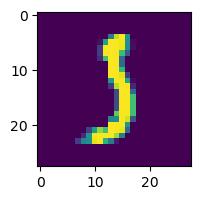

Mismatch for image 133: predicted 8, true label 9


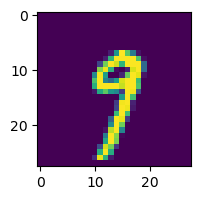

Mismatch for image 134: predicted 8, true label 1


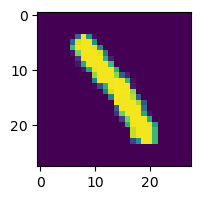

Mismatch for image 135: predicted 8, true label 3


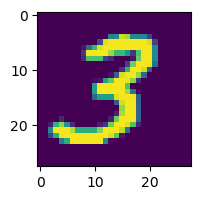

Mismatch for image 136: predicted 8, true label 3


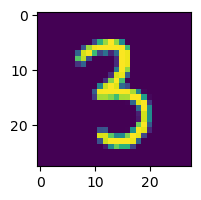

Mismatch for image 138: predicted 8, true label 5


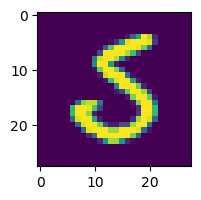

Mismatch for image 139: predicted 8, true label 4


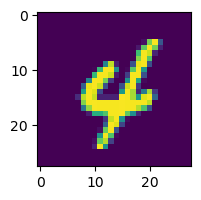

Mismatch for image 140: predicted 8, true label 7


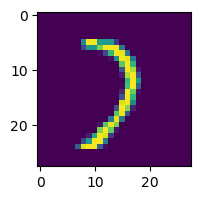

Mismatch for image 141: predicted 8, true label 7


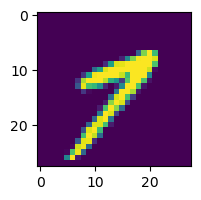

Mismatch for image 142: predicted 8, true label 4


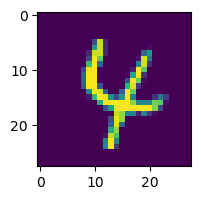

Mismatch for image 143: predicted 8, true label 2


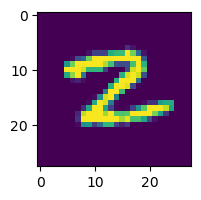

Mismatch for image 145: predicted 8, true label 5


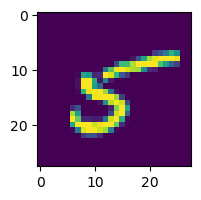

Mismatch for image 147: predicted 8, true label 6


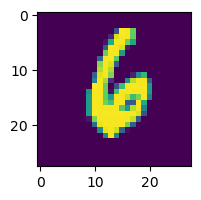

Mismatch for image 148: predicted 8, true label 7


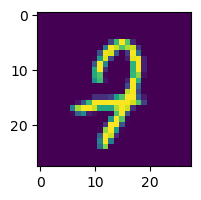

Mismatch for image 149: predicted 8, true label 3


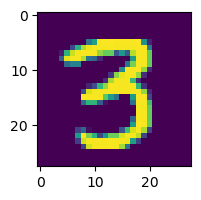

Mismatch for image 150: predicted 8, true label 4


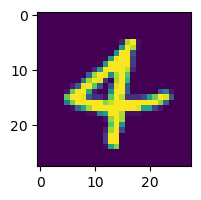

Mismatch for image 151: predicted 8, true label 6


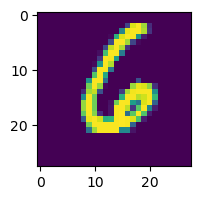

Mismatch for image 152: predicted 8, true label 1


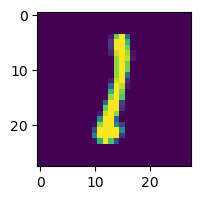

Mismatch for image 153: predicted 8, true label 9


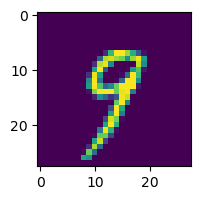

Mismatch for image 154: predicted 8, true label 9


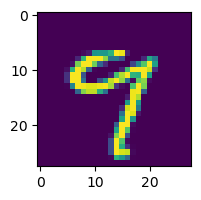

Mismatch for image 155: predicted 8, true label 6


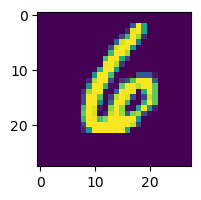

Mismatch for image 156: predicted 8, true label 0


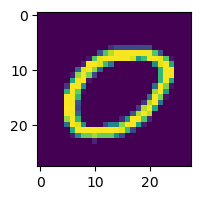

Mismatch for image 157: predicted 8, true label 3


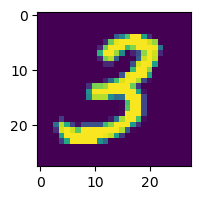

Mismatch for image 158: predicted 8, true label 7


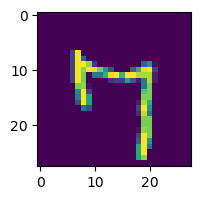

Mismatch for image 159: predicted 8, true label 2


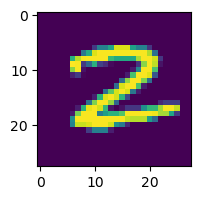

Mismatch for image 161: predicted 8, true label 2


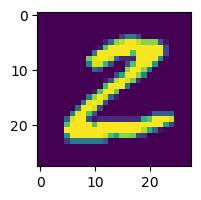

Mismatch for image 162: predicted 8, true label 9


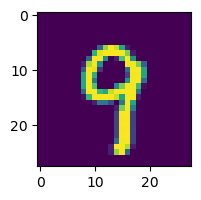

Mismatch for image 163: predicted 8, true label 4


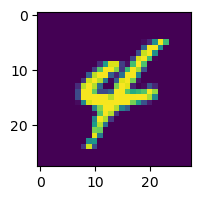

Mismatch for image 164: predicted 8, true label 4


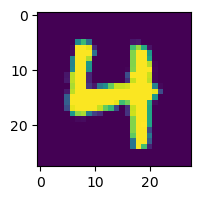

Mismatch for image 165: predicted 8, true label 6


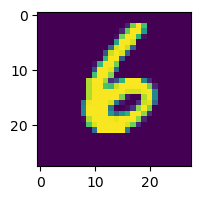

Mismatch for image 166: predicted 8, true label 4


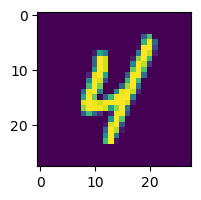

Mismatch for image 167: predicted 8, true label 9


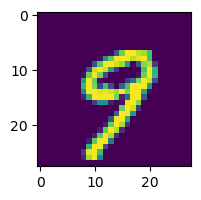

Mismatch for image 168: predicted 8, true label 7


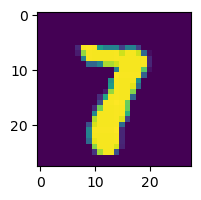

Mismatch for image 169: predicted 8, true label 0


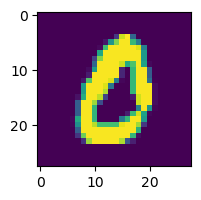

Mismatch for image 170: predicted 8, true label 9


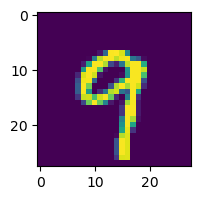

Mismatch for image 171: predicted 8, true label 2


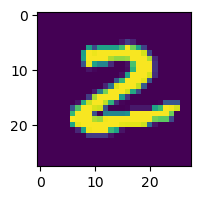

Mismatch for image 172: predicted 8, true label 9


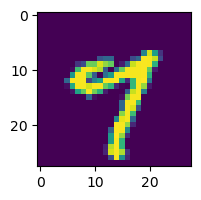

Mismatch for image 173: predicted 8, true label 5


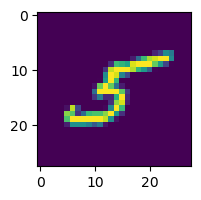

Mismatch for image 174: predicted 8, true label 1


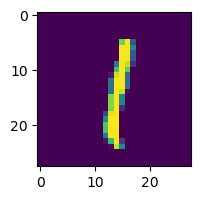

Mismatch for image 175: predicted 8, true label 5


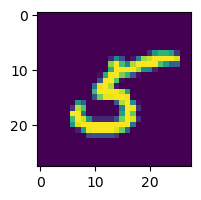

Mismatch for image 176: predicted 8, true label 9


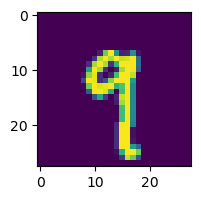

Mismatch for image 177: predicted 8, true label 1


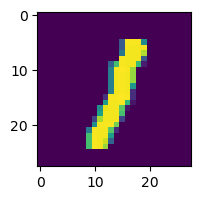

Mismatch for image 178: predicted 8, true label 2


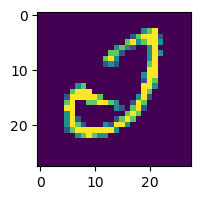

Mismatch for image 179: predicted 8, true label 3


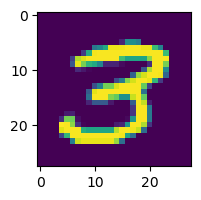

Mismatch for image 180: predicted 8, true label 2


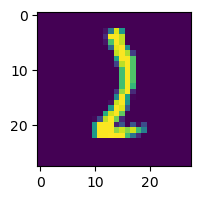

Mismatch for image 181: predicted 8, true label 3


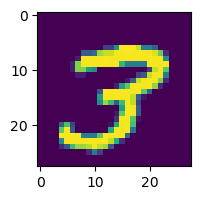

Mismatch for image 182: predicted 8, true label 5


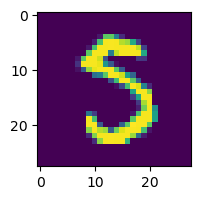

Mismatch for image 183: predicted 8, true label 9


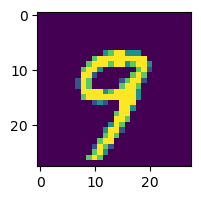

Mismatch for image 184: predicted 8, true label 1


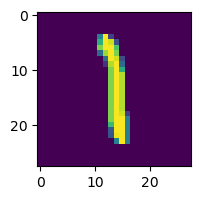

Mismatch for image 185: predicted 8, true label 7


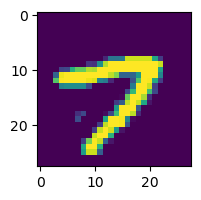

Mismatch for image 186: predicted 8, true label 6


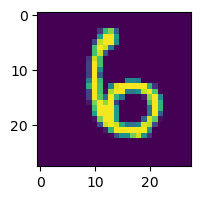

Mismatch for image 187: predicted 8, true label 2


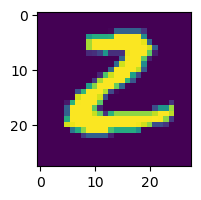

Mismatch for image 189: predicted 8, true label 2


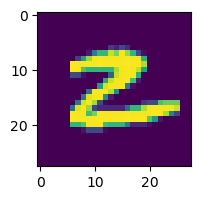

Mismatch for image 190: predicted 8, true label 2


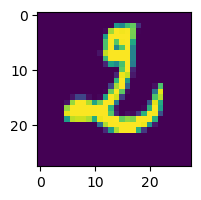

Mismatch for image 191: predicted 8, true label 5


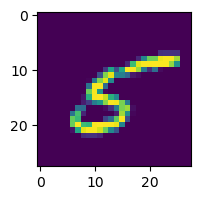

Mismatch for image 192: predicted 8, true label 0


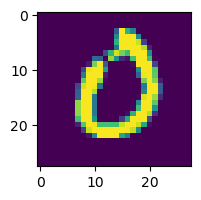

Mismatch for image 193: predicted 8, true label 7


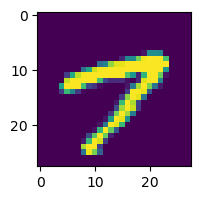

Mismatch for image 194: predicted 8, true label 4


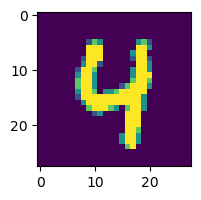

Mismatch for image 195: predicted 8, true label 9


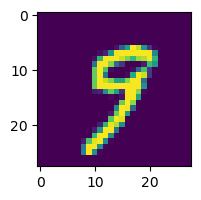

Mismatch for image 196: predicted 8, true label 7


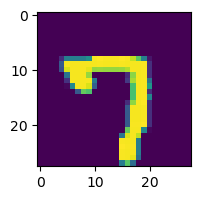

Mismatch for image 198: predicted 8, true label 3


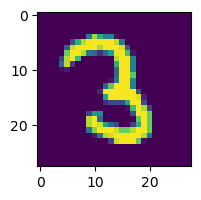

Mismatch for image 199: predicted 8, true label 2


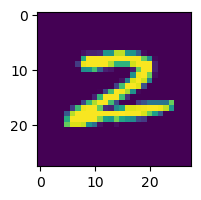

Mismatch for image 200: predicted 8, true label 1


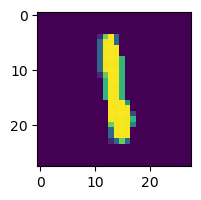

Mismatch for image 201: predicted 8, true label 1


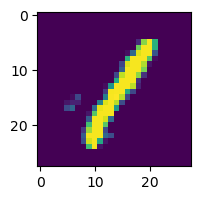

Mismatch for image 203: predicted 8, true label 3


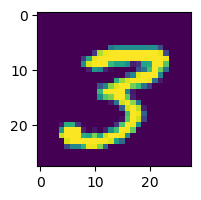

Mismatch for image 204: predicted 8, true label 6


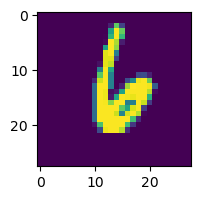

Mismatch for image 205: predicted 8, true label 1


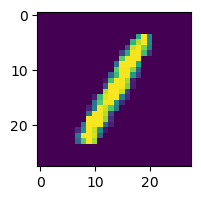

Mismatch for image 206: predicted 8, true label 0


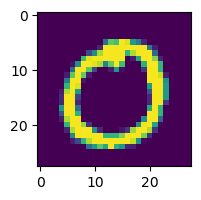

Mismatch for image 207: predicted 8, true label 3


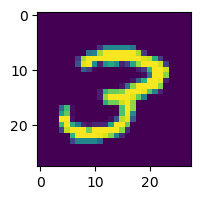

Mismatch for image 208: predicted 8, true label 1


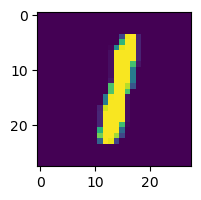

Mismatch for image 209: predicted 8, true label 0


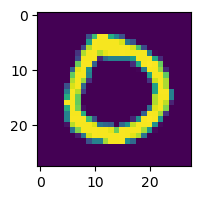

Mismatch for image 210: predicted 8, true label 0


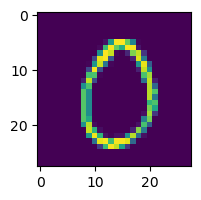

Mismatch for image 211: predicted 8, true label 1


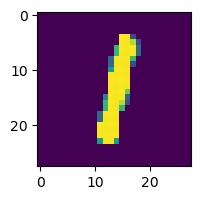

Mismatch for image 212: predicted 8, true label 7


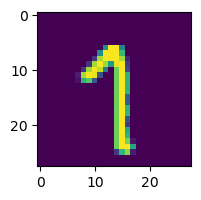

Mismatch for image 213: predicted 8, true label 2


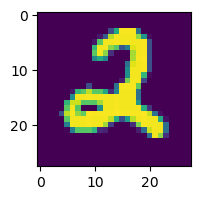

Mismatch for image 214: predicted 8, true label 7


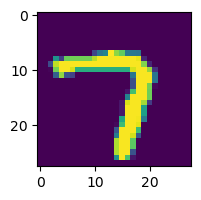

Mismatch for image 215: predicted 8, true label 3


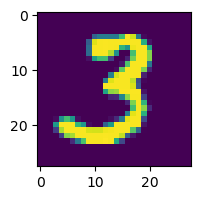

Mismatch for image 216: predicted 8, true label 0


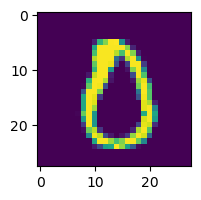

Mismatch for image 217: predicted 8, true label 4


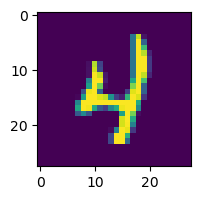

Mismatch for image 218: predicted 8, true label 6


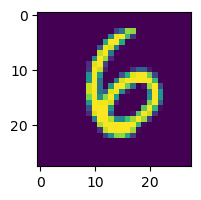

Mismatch for image 219: predicted 8, true label 5


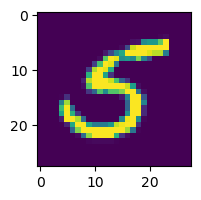

Mismatch for image 220: predicted 8, true label 2


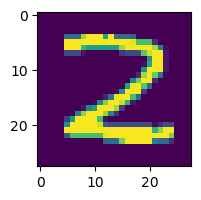

Mismatch for image 221: predicted 8, true label 6


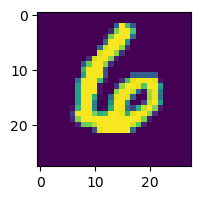

Mismatch for image 222: predicted 8, true label 4


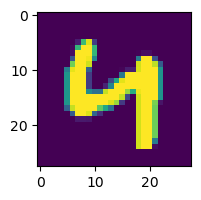

Mismatch for image 223: predicted 8, true label 7


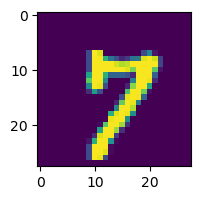

Mismatch for image 224: predicted 8, true label 1


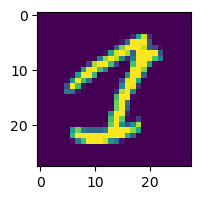

Mismatch for image 226: predicted 8, true label 9


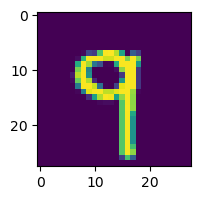

Mismatch for image 227: predicted 8, true label 9


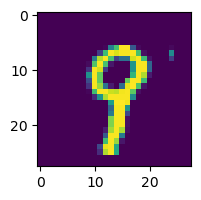

Mismatch for image 228: predicted 8, true label 3


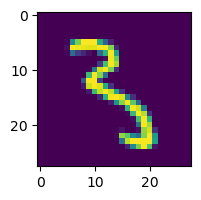

Mismatch for image 229: predicted 8, true label 0


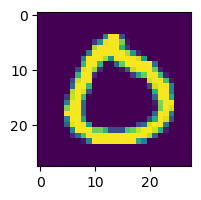

Mismatch for image 230: predicted 8, true label 7


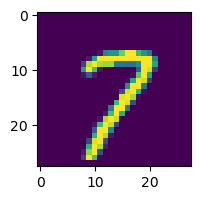

Mismatch for image 231: predicted 8, true label 1


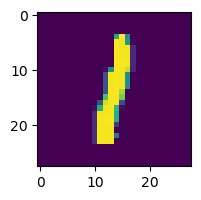

Mismatch for image 232: predicted 8, true label 0


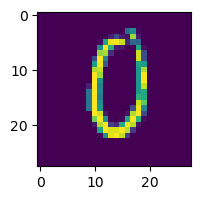

Mismatch for image 233: predicted 8, true label 2


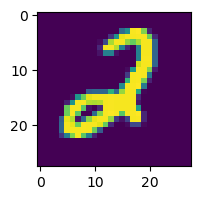

Mismatch for image 234: predicted 8, true label 0


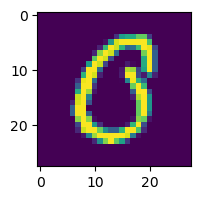

Mismatch for image 235: predicted 8, true label 3


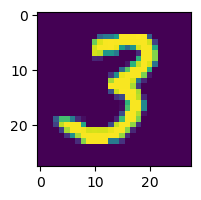

Mismatch for image 236: predicted 8, true label 5


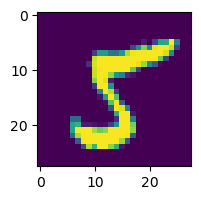

Mismatch for image 237: predicted 8, true label 4


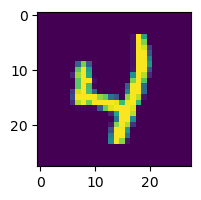

Mismatch for image 238: predicted 8, true label 6


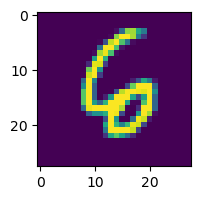

Mismatch for image 239: predicted 8, true label 5


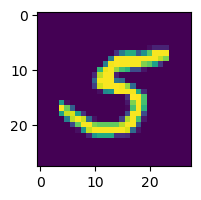

Mismatch for image 241: predicted 8, true label 6


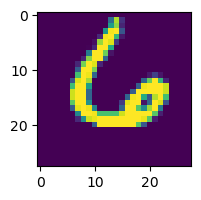

Mismatch for image 242: predicted 8, true label 3


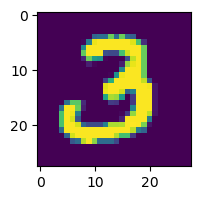

Mismatch for image 243: predicted 8, true label 7


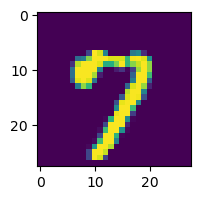

Mismatch for image 244: predicted 8, true label 5


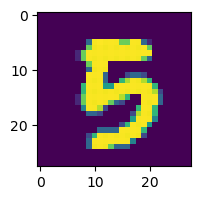

Mismatch for image 246: predicted 8, true label 0


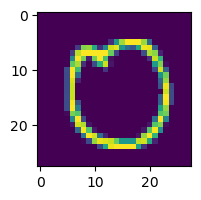

Mismatch for image 247: predicted 8, true label 9


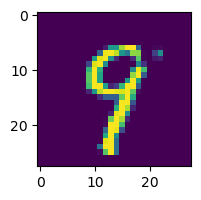

Mismatch for image 248: predicted 8, true label 1


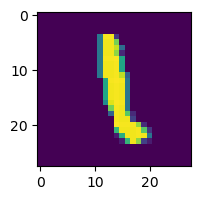

Mismatch for image 249: predicted 8, true label 0


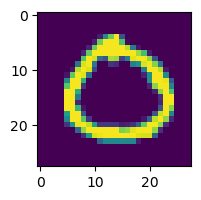

Mismatch for image 250: predicted 8, true label 3


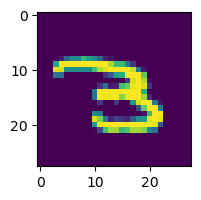

Mismatch for image 251: predicted 8, true label 1


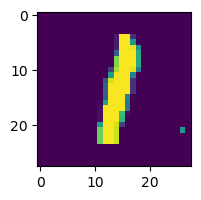

Mismatch for image 252: predicted 8, true label 2


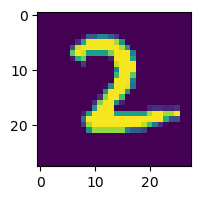

Mismatch for image 253: predicted 8, true label 2


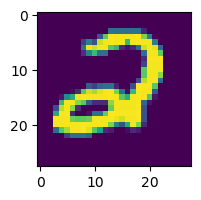

Mismatch for image 254: predicted 8, true label 3


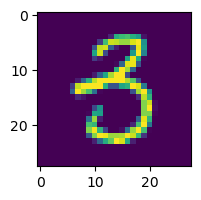

Mismatch for image 255: predicted 8, true label 3


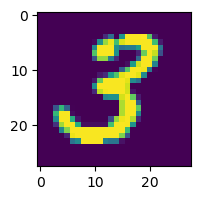

Mismatch for image 256: predicted 8, true label 6


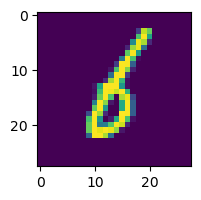

Mismatch for image 257: predicted 8, true label 4


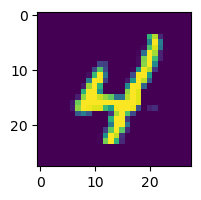

Mismatch for image 258: predicted 8, true label 7


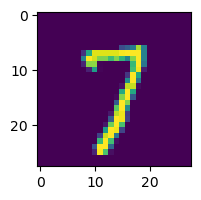

Mismatch for image 259: predicted 8, true label 5


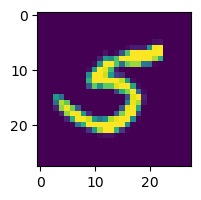

Mismatch for image 260: predicted 8, true label 0


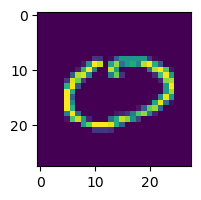

Mismatch for image 261: predicted 8, true label 6


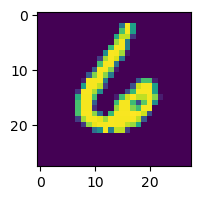

Mismatch for image 262: predicted 8, true label 2


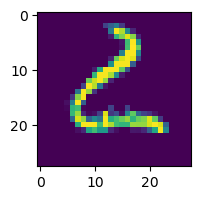

Mismatch for image 263: predicted 8, true label 7


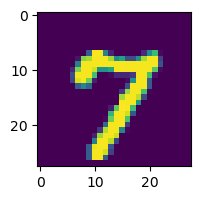

Mismatch for image 264: predicted 8, true label 9


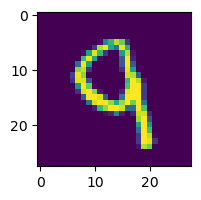

Mismatch for image 266: predicted 8, true label 5


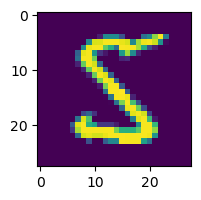

Mismatch for image 267: predicted 8, true label 9


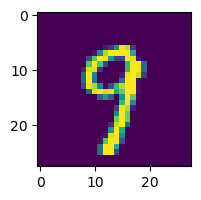

Mismatch for image 268: predicted 8, true label 2


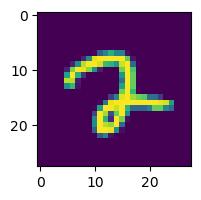

Mismatch for image 269: predicted 8, true label 1


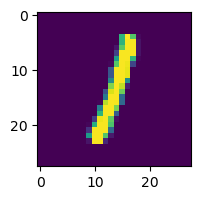

Mismatch for image 270: predicted 8, true label 1


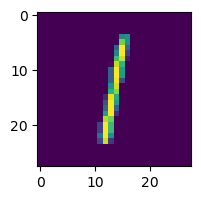

Mismatch for image 271: predicted 8, true label 4


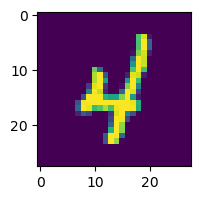

Mismatch for image 272: predicted 8, true label 4


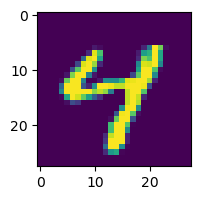

Mismatch for image 273: predicted 8, true label 5


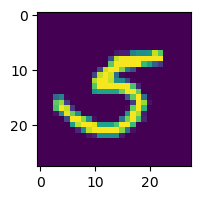

Mismatch for image 274: predicted 8, true label 6


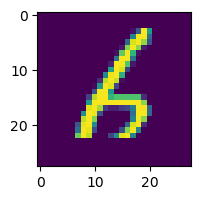

Mismatch for image 275: predicted 8, true label 4


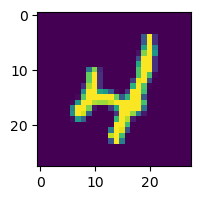

Mismatch for image 276: predicted 8, true label 1


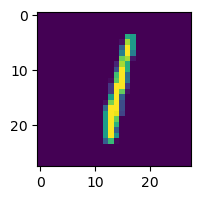

Mismatch for image 277: predicted 8, true label 2


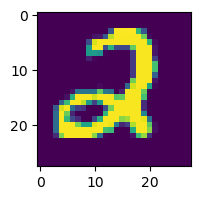

Mismatch for image 278: predicted 8, true label 5


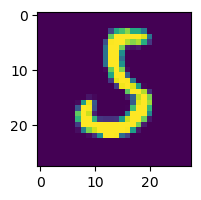

Mismatch for image 279: predicted 8, true label 3


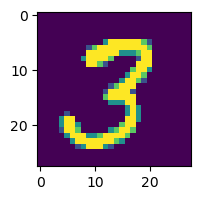

Mismatch for image 280: predicted 8, true label 9


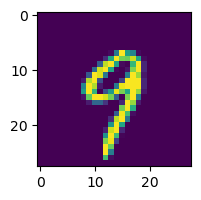

Mismatch for image 281: predicted 8, true label 3


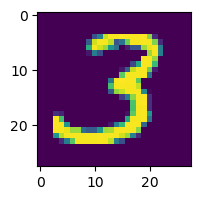

Mismatch for image 282: predicted 8, true label 9


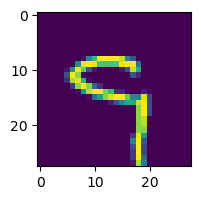

Mismatch for image 283: predicted 8, true label 0


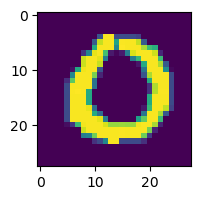

Mismatch for image 284: predicted 8, true label 5


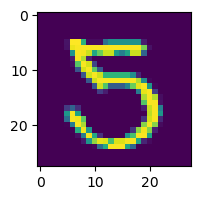

Mismatch for image 285: predicted 8, true label 9


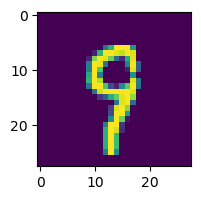

Mismatch for image 286: predicted 8, true label 6


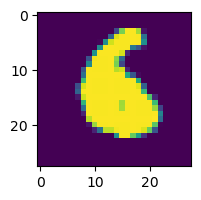

Mismatch for image 287: predicted 8, true label 5


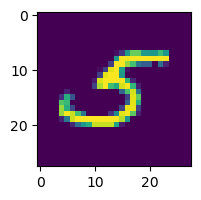

Mismatch for image 288: predicted 8, true label 7


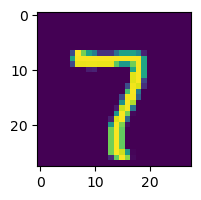

Mismatch for image 289: predicted 8, true label 4


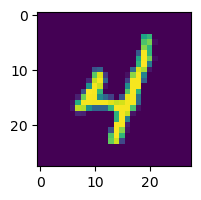

Mismatch for image 290: predicted 8, true label 1


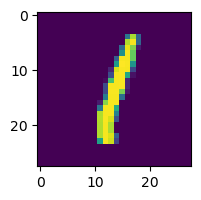

Mismatch for image 291: predicted 8, true label 3


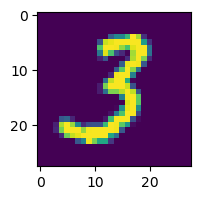

Mismatch for image 292: predicted 8, true label 4


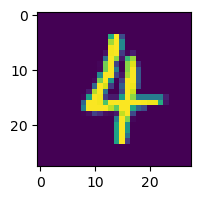

Mismatch for image 293: predicted 8, true label 0


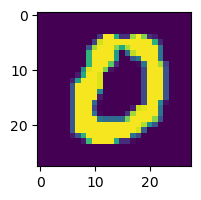

Mismatch for image 294: predicted 8, true label 4


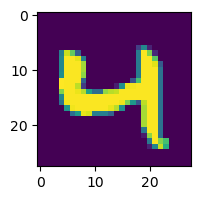

Mismatch for image 296: predicted 8, true label 0


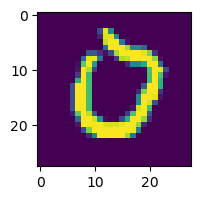

Mismatch for image 297: predicted 8, true label 4


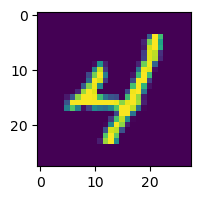

Mismatch for image 298: predicted 8, true label 3


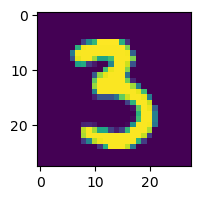

Mismatch for image 299: predicted 8, true label 6


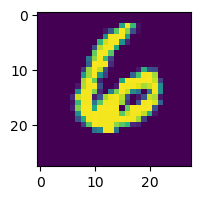

Mismatch for image 301: predicted 8, true label 7


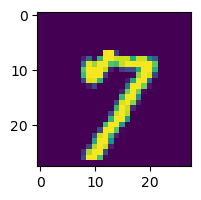

Mismatch for image 302: predicted 8, true label 6


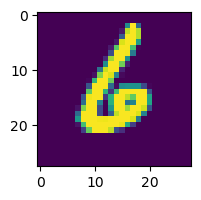

Mismatch for image 303: predicted 8, true label 0


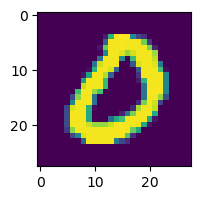

Mismatch for image 304: predicted 8, true label 9


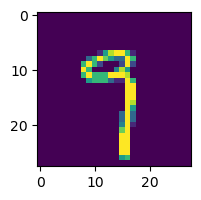

Mismatch for image 305: predicted 8, true label 7


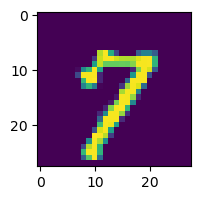

Mismatch for image 306: predicted 8, true label 5


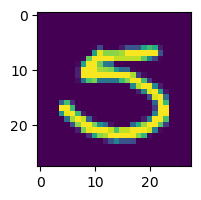

Mismatch for image 307: predicted 8, true label 7


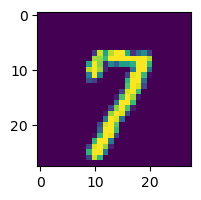

Mismatch for image 308: predicted 8, true label 2


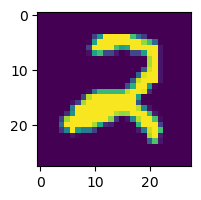

Mismatch for image 309: predicted 8, true label 1


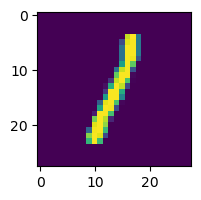

Mismatch for image 310: predicted 8, true label 1


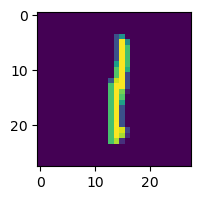

Mismatch for image 311: predicted 8, true label 6


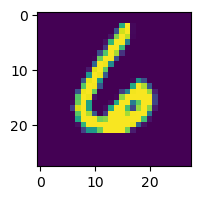

Mismatch for image 313: predicted 8, true label 9


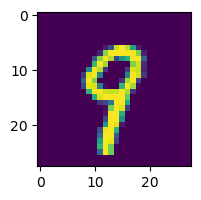

Mismatch for image 314: predicted 8, true label 4


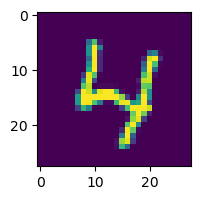

Mismatch for image 315: predicted 8, true label 1


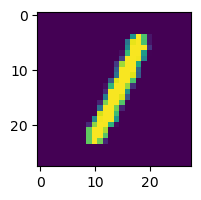

Mismatch for image 316: predicted 8, true label 5


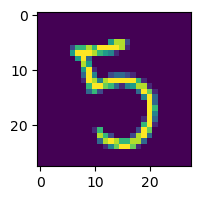

Mismatch for image 317: predicted 8, true label 2


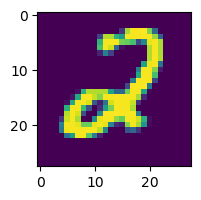

Mismatch for image 318: predicted 8, true label 2


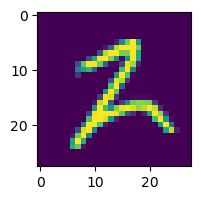

Mismatch for image 319: predicted 8, true label 9


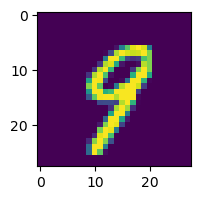

Mismatch for image 320: predicted 8, true label 0


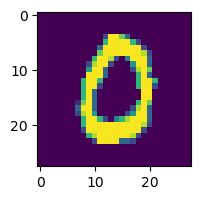

Mismatch for image 321: predicted 8, true label 3


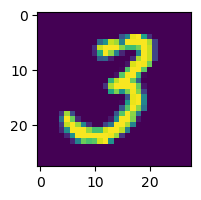

Mismatch for image 322: predicted 8, true label 9


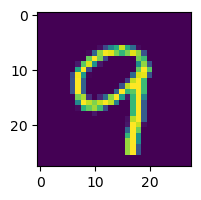

Mismatch for image 323: predicted 8, true label 6


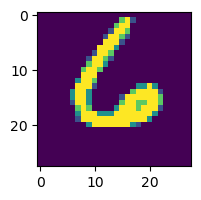

Mismatch for image 324: predicted 8, true label 7


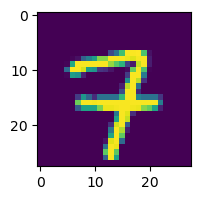

Mismatch for image 325: predicted 8, true label 2


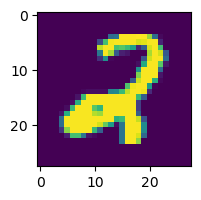

Mismatch for image 326: predicted 8, true label 0


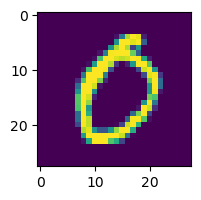

Mismatch for image 327: predicted 8, true label 3


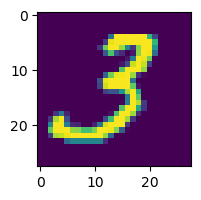

Mismatch for image 328: predicted 8, true label 5


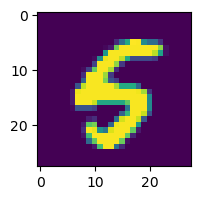

Mismatch for image 329: predicted 8, true label 4


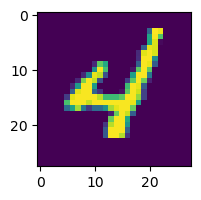

Mismatch for image 330: predicted 8, true label 3


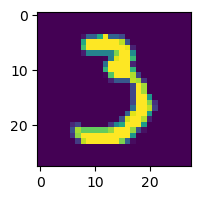

Mismatch for image 331: predicted 8, true label 6


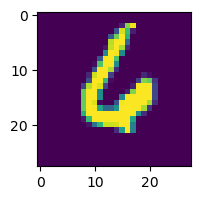

Mismatch for image 332: predicted 8, true label 5


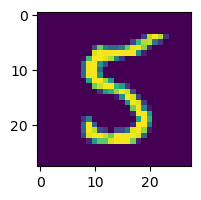

Mismatch for image 334: predicted 8, true label 9


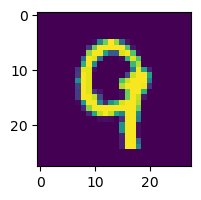

Mismatch for image 335: predicted 8, true label 5


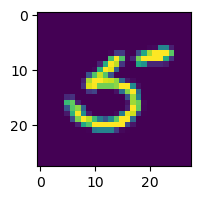

Mismatch for image 336: predicted 8, true label 4


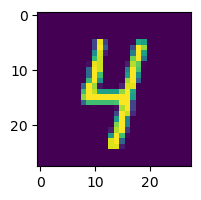

Mismatch for image 337: predicted 8, true label 7


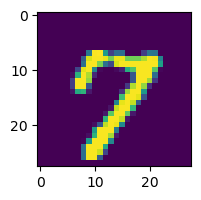

Mismatch for image 338: predicted 8, true label 4


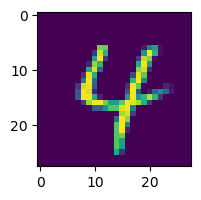

Mismatch for image 339: predicted 8, true label 2


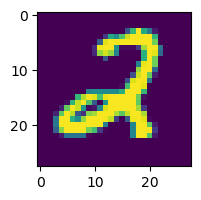

Mismatch for image 340: predicted 8, true label 7


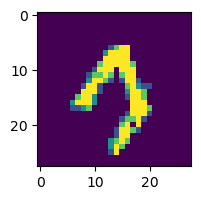

Mismatch for image 341: predicted 8, true label 3


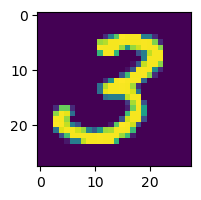

Mismatch for image 342: predicted 8, true label 4


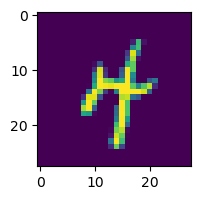

Mismatch for image 344: predicted 8, true label 9


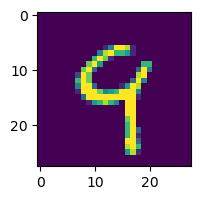

Mismatch for image 345: predicted 8, true label 1


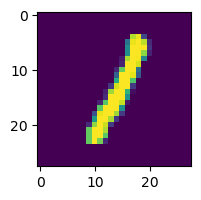

Mismatch for image 346: predicted 8, true label 9


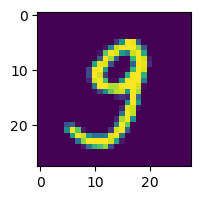

Mismatch for image 347: predicted 8, true label 2


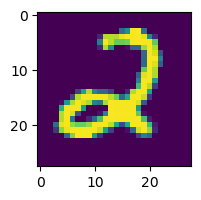

Mismatch for image 349: predicted 8, true label 7


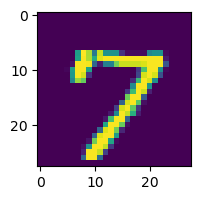

Mismatch for image 350: predicted 8, true label 9


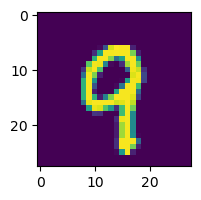

Mismatch for image 351: predicted 8, true label 1


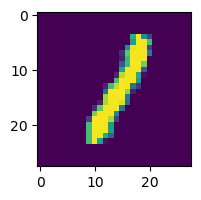

Mismatch for image 353: predicted 8, true label 7


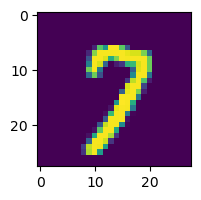

Mismatch for image 354: predicted 8, true label 4


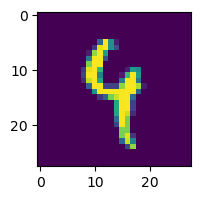

Mismatch for image 355: predicted 8, true label 1


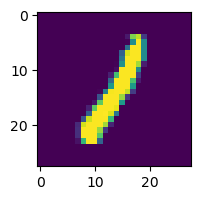

Mismatch for image 356: predicted 8, true label 3


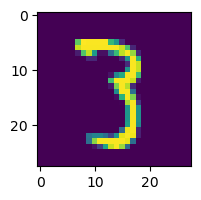

Mismatch for image 357: predicted 8, true label 1


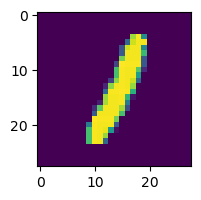

Mismatch for image 358: predicted 8, true label 1


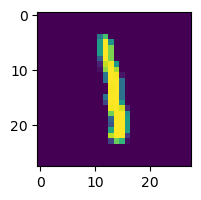

Mismatch for image 359: predicted 8, true label 0


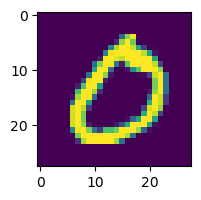

Mismatch for image 360: predicted 8, true label 2


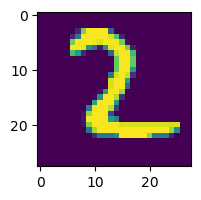

Mismatch for image 361: predicted 8, true label 3


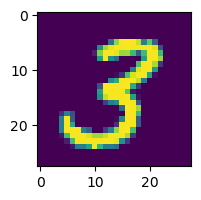

Mismatch for image 362: predicted 8, true label 9


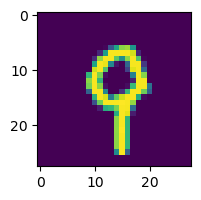

Mismatch for image 363: predicted 8, true label 4


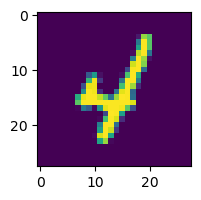

Mismatch for image 364: predicted 8, true label 9


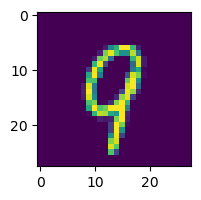

Mismatch for image 365: predicted 8, true label 2


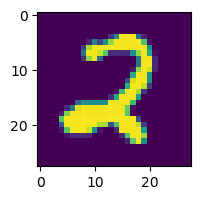

Mismatch for image 366: predicted 8, true label 1


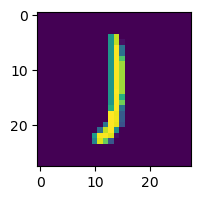

Mismatch for image 367: predicted 8, true label 6


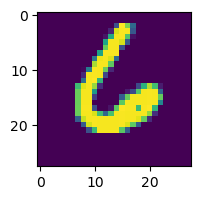

Mismatch for image 369: predicted 8, true label 4


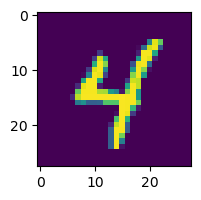

Mismatch for image 370: predicted 8, true label 7


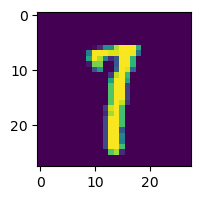

Mismatch for image 371: predicted 8, true label 7


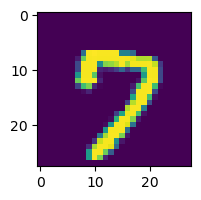

Mismatch for image 372: predicted 8, true label 4


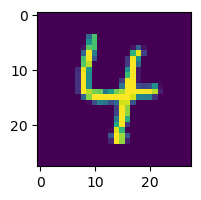

Mismatch for image 373: predicted 8, true label 4


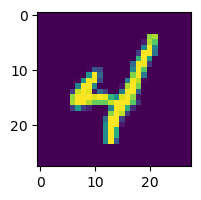

Mismatch for image 374: predicted 8, true label 9


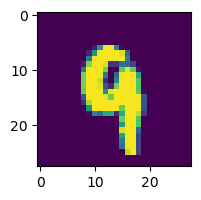

Mismatch for image 375: predicted 8, true label 2


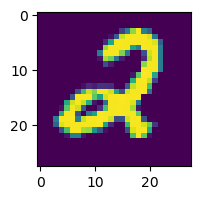

Mismatch for image 376: predicted 8, true label 5


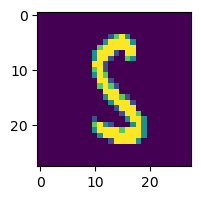

Mismatch for image 377: predicted 8, true label 7


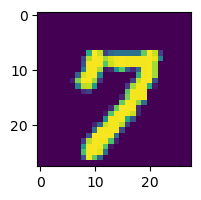

Mismatch for image 378: predicted 8, true label 2


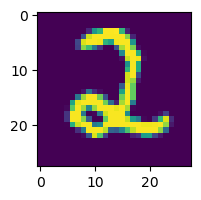

Mismatch for image 379: predicted 8, true label 4


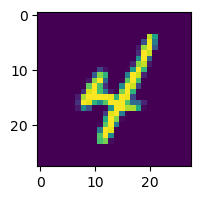

Mismatch for image 380: predicted 8, true label 4


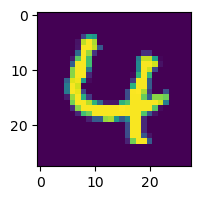

Mismatch for image 381: predicted 8, true label 2


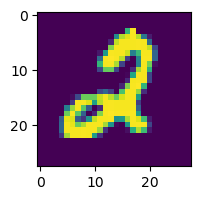

Mismatch for image 382: predicted 8, true label 1


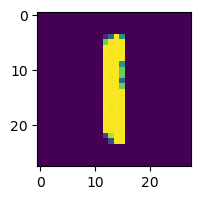

Mismatch for image 383: predicted 8, true label 9


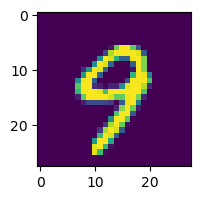

Mismatch for image 384: predicted 8, true label 7


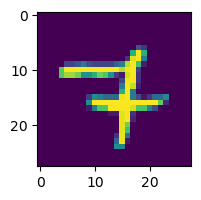

Mismatch for image 385: predicted 8, true label 2


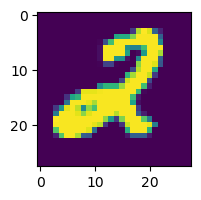

Mismatch for image 387: predicted 8, true label 7


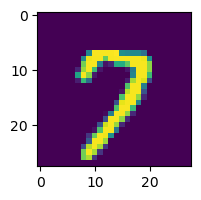

Mismatch for image 388: predicted 8, true label 6


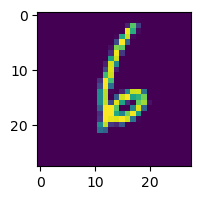

Mismatch for image 389: predicted 8, true label 9


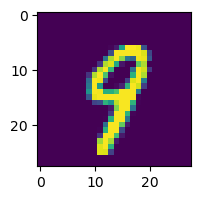

Mismatch for image 390: predicted 8, true label 2


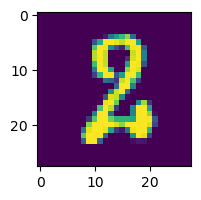

Mismatch for image 391: predicted 8, true label 2


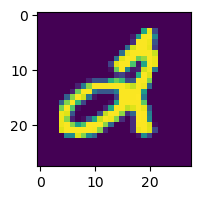

Mismatch for image 392: predicted 8, true label 3


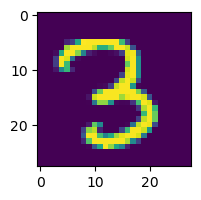

Mismatch for image 394: predicted 8, true label 1


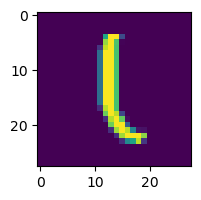

Mismatch for image 395: predicted 8, true label 6


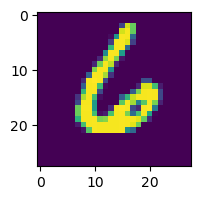

Mismatch for image 396: predicted 8, true label 5


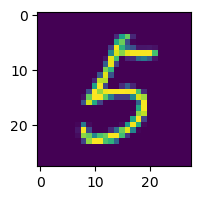

Mismatch for image 397: predicted 8, true label 1


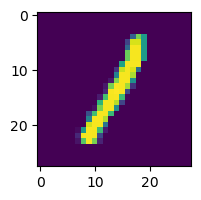

Mismatch for image 398: predicted 8, true label 1


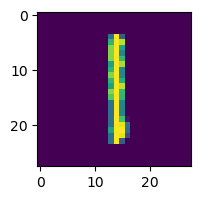

Mismatch for image 399: predicted 8, true label 0


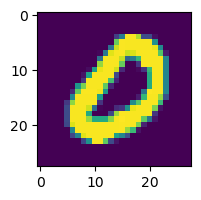

Mismatch for image 400: predicted 8, true label 2


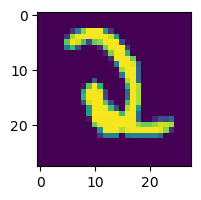

Mismatch for image 401: predicted 8, true label 6


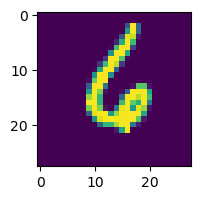

Mismatch for image 402: predicted 8, true label 4


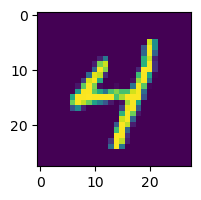

Mismatch for image 403: predicted 8, true label 5


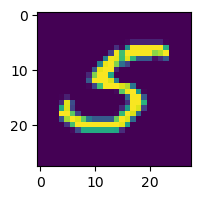

Mismatch for image 405: predicted 8, true label 3


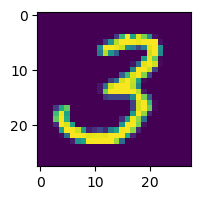

Mismatch for image 406: predicted 8, true label 1


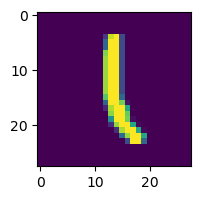

Mismatch for image 407: predicted 8, true label 5


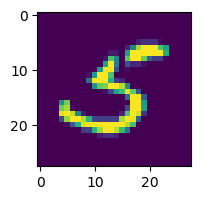

Mismatch for image 408: predicted 8, true label 1


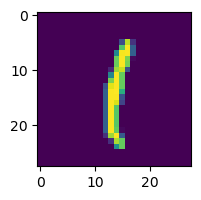

Mismatch for image 409: predicted 8, true label 9


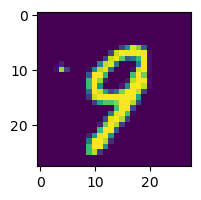

Mismatch for image 410: predicted 8, true label 2


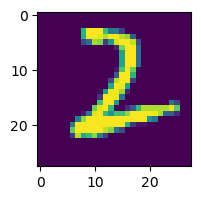

Mismatch for image 411: predicted 8, true label 7


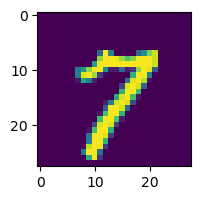

Mismatch for image 412: predicted 8, true label 4


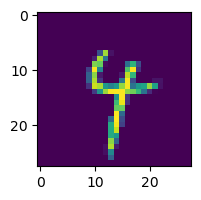

Mismatch for image 413: predicted 8, true label 4


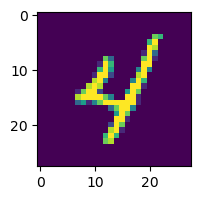

Mismatch for image 414: predicted 8, true label 4


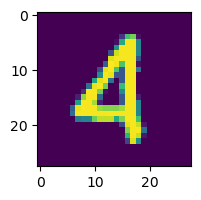

Mismatch for image 416: predicted 8, true label 1


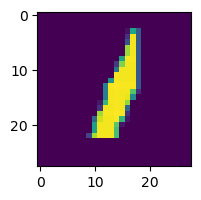

Mismatch for image 417: predicted 8, true label 5


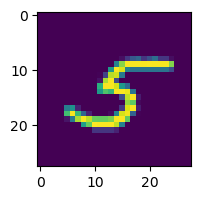

Mismatch for image 419: predicted 8, true label 9


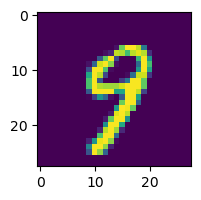

Mismatch for image 420: predicted 8, true label 5


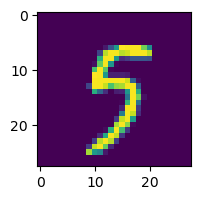

Mismatch for image 421: predicted 8, true label 6


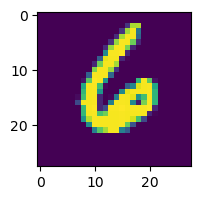

Mismatch for image 422: predicted 8, true label 7


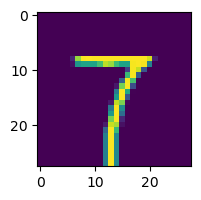

Mismatch for image 423: predicted 8, true label 9


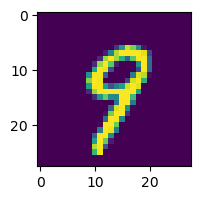

Mismatch for image 424: predicted 8, true label 9


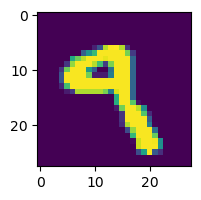

Mismatch for image 425: predicted 8, true label 3


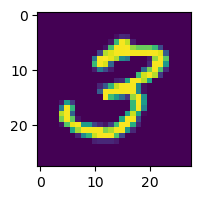

Mismatch for image 426: predicted 8, true label 7


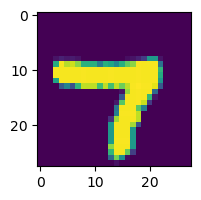

Mismatch for image 427: predicted 8, true label 0


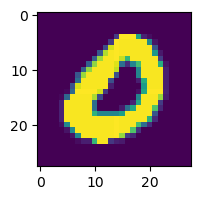

Mismatch for image 428: predicted 8, true label 9


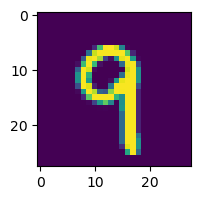

Mismatch for image 429: predicted 8, true label 0


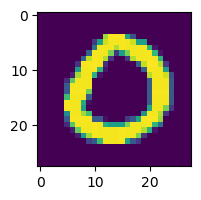

Mismatch for image 430: predicted 8, true label 6


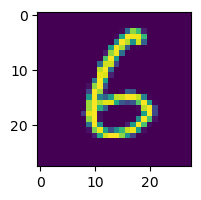

Mismatch for image 431: predicted 8, true label 6


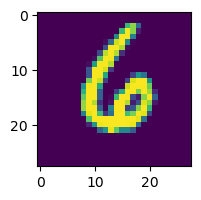

Mismatch for image 432: predicted 8, true label 2


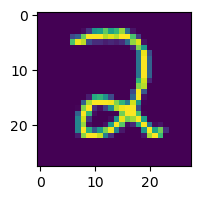

Mismatch for image 433: predicted 8, true label 3


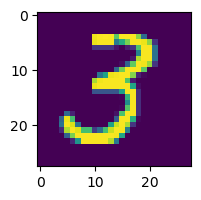

Mismatch for image 434: predicted 8, true label 9


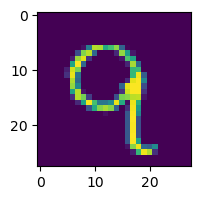

Mismatch for image 435: predicted 8, true label 0


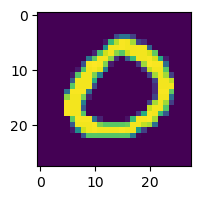

Mismatch for image 436: predicted 8, true label 7


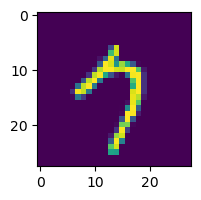

Mismatch for image 437: predicted 8, true label 5


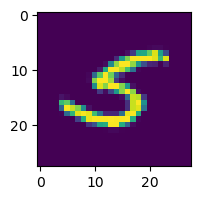

Mismatch for image 438: predicted 8, true label 4


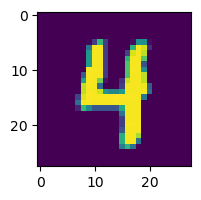

Mismatch for image 440: predicted 8, true label 0


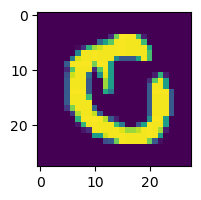

Mismatch for image 441: predicted 8, true label 9


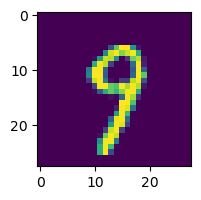

Mismatch for image 442: predicted 8, true label 4


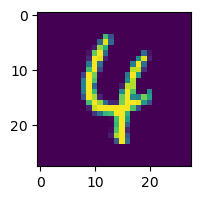

Mismatch for image 443: predicted 8, true label 1


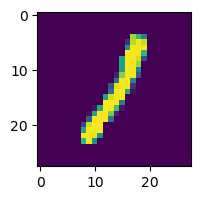

Mismatch for image 444: predicted 8, true label 2


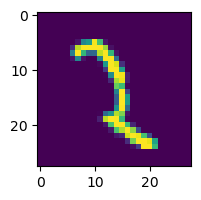

Mismatch for image 446: predicted 8, true label 7


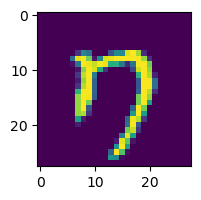

Mismatch for image 447: predicted 8, true label 1


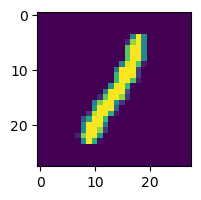

Mismatch for image 448: predicted 8, true label 2


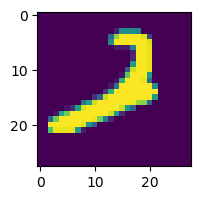

Mismatch for image 449: predicted 8, true label 6


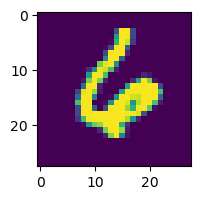

Mismatch for image 450: predicted 8, true label 1


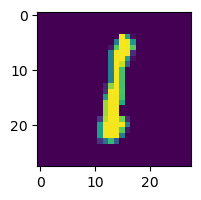

Mismatch for image 451: predicted 8, true label 0


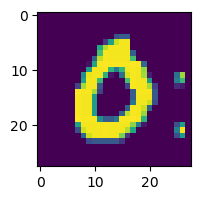

Mismatch for image 452: predicted 8, true label 3


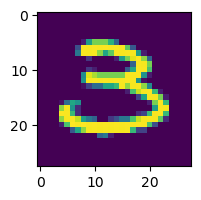

Mismatch for image 453: predicted 8, true label 0


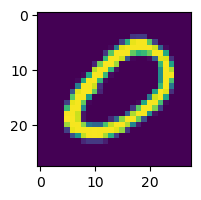

Mismatch for image 454: predicted 8, true label 1


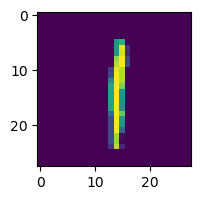

Mismatch for image 455: predicted 8, true label 1


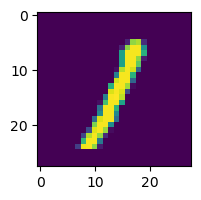

Mismatch for image 457: predicted 8, true label 2


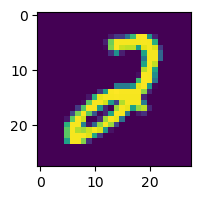

Mismatch for image 458: predicted 8, true label 0


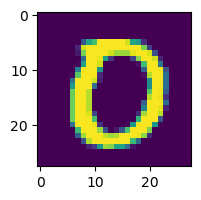

Mismatch for image 459: predicted 8, true label 3


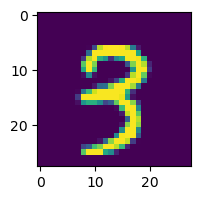

Mismatch for image 460: predicted 8, true label 9


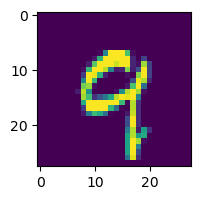

Mismatch for image 461: predicted 8, true label 4


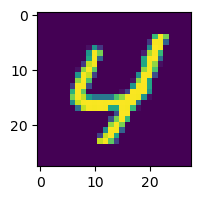

Mismatch for image 462: predicted 8, true label 0


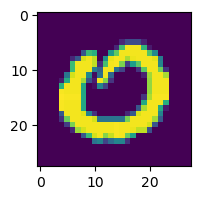

Mismatch for image 463: predicted 8, true label 5


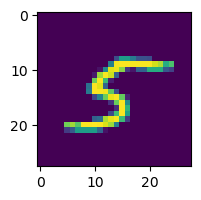

Mismatch for image 464: predicted 8, true label 0


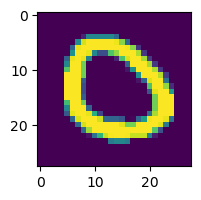

Mismatch for image 465: predicted 8, true label 6


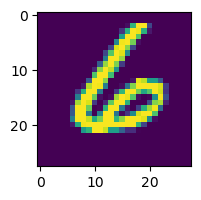

Mismatch for image 466: predicted 8, true label 1


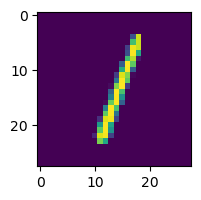

Mismatch for image 467: predicted 8, true label 7


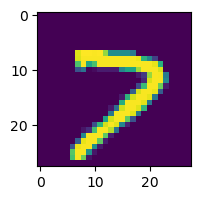

Mismatch for image 468: predicted 8, true label 7


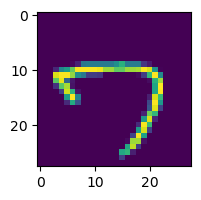

Mismatch for image 470: predicted 8, true label 1


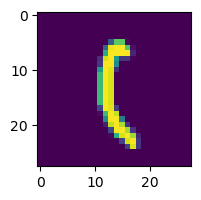

Mismatch for image 471: predicted 8, true label 9


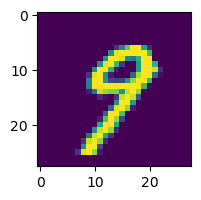

Mismatch for image 472: predicted 8, true label 2


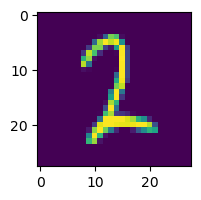

Mismatch for image 473: predicted 8, true label 0


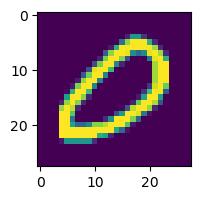

Mismatch for image 474: predicted 8, true label 5


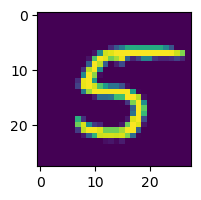

Mismatch for image 475: predicted 8, true label 1


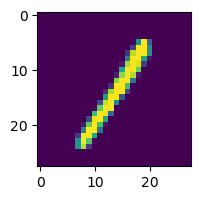

Mismatch for image 476: predicted 8, true label 2


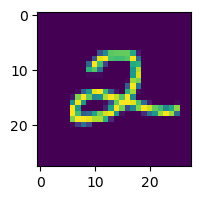

Mismatch for image 477: predicted 8, true label 2


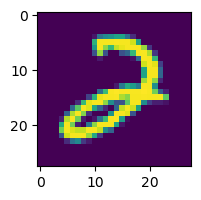

Mismatch for image 478: predicted 8, true label 7


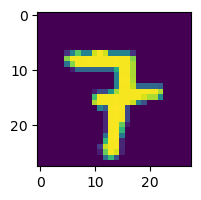

Mismatch for image 479: predicted 8, true label 3


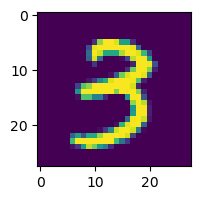

Mismatch for image 480: predicted 8, true label 5


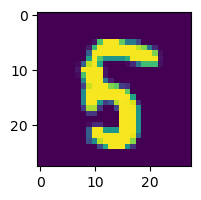

Mismatch for image 481: predicted 8, true label 4


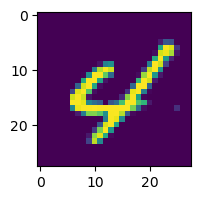

Mismatch for image 482: predicted 8, true label 9


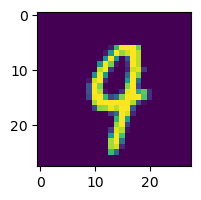

Mismatch for image 483: predicted 8, true label 7


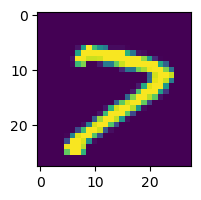

Mismatch for image 484: predicted 8, true label 1


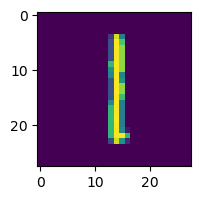

Mismatch for image 486: predicted 8, true label 3


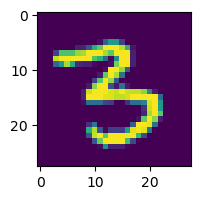

Mismatch for image 487: predicted 8, true label 9


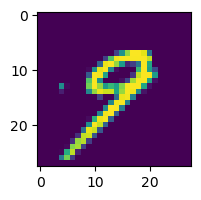

Mismatch for image 488: predicted 8, true label 6


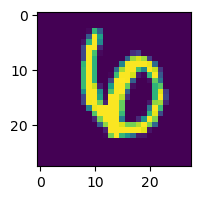

Mismatch for image 489: predicted 8, true label 0


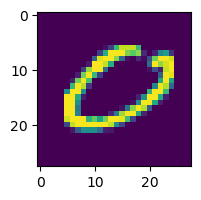

Mismatch for image 490: predicted 8, true label 3


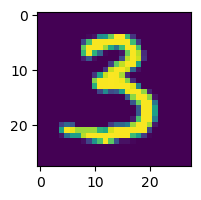

Mismatch for image 491: predicted 8, true label 1


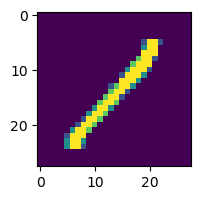

Mismatch for image 492: predicted 8, true label 1


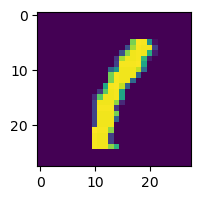

Mismatch for image 493: predicted 8, true label 2


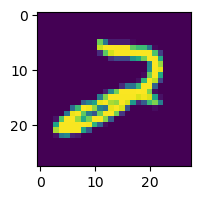

Mismatch for image 494: predicted 8, true label 6


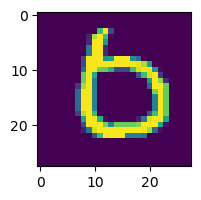

Mismatch for image 495: predicted 8, true label 3


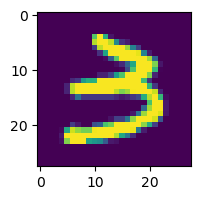

Mismatch for image 496: predicted 8, true label 5


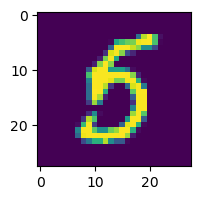

Mismatch for image 497: predicted 8, true label 7


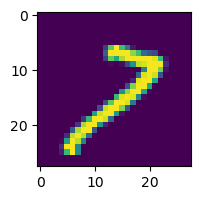

Mismatch for image 498: predicted 8, true label 6


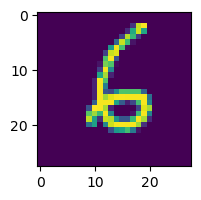

Mismatch for image 500: predicted 8, true label 3


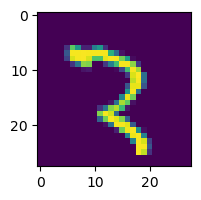

Mismatch for image 501: predicted 8, true label 9


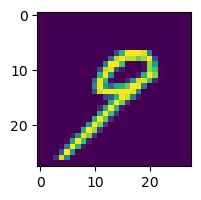

Mismatch for image 502: predicted 8, true label 5


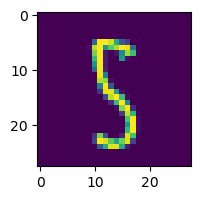

Mismatch for image 504: predicted 8, true label 5


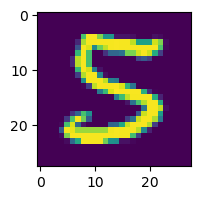

Mismatch for image 505: predicted 8, true label 7


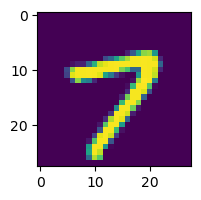

Mismatch for image 506: predicted 8, true label 6


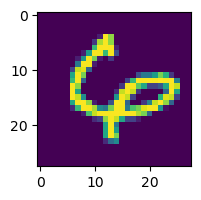

Mismatch for image 507: predicted 8, true label 1


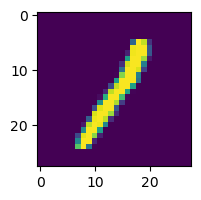

Mismatch for image 508: predicted 8, true label 1


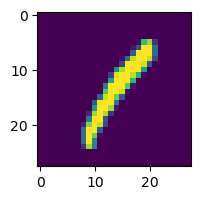

Mismatch for image 509: predicted 8, true label 3


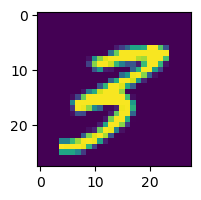

Mismatch for image 510: predicted 8, true label 1


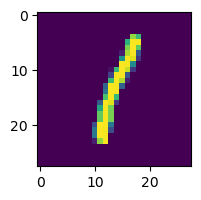

Mismatch for image 511: predicted 8, true label 7


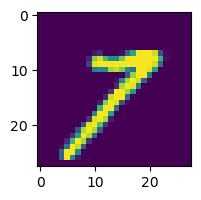

Mismatch for image 512: predicted 8, true label 5


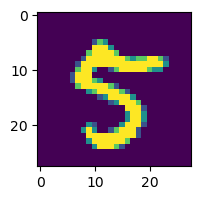

Mismatch for image 513: predicted 8, true label 5


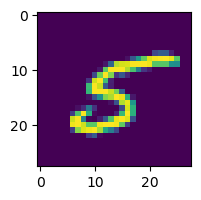

Mismatch for image 514: predicted 8, true label 5


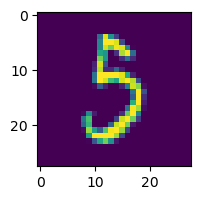

Mismatch for image 515: predicted 8, true label 2


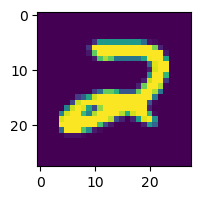

Mismatch for image 516: predicted 8, true label 5


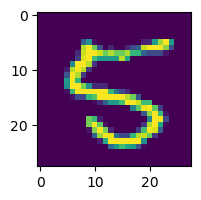

Mismatch for image 518: predicted 8, true label 7


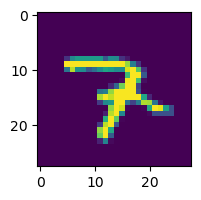

Mismatch for image 519: predicted 8, true label 0


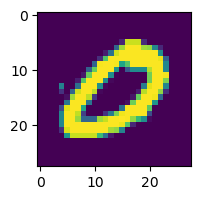

Mismatch for image 520: predicted 8, true label 9


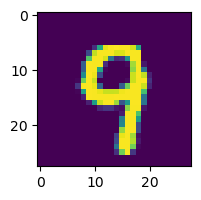

Mismatch for image 521: predicted 8, true label 7


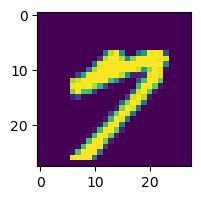

Mismatch for image 522: predicted 8, true label 7


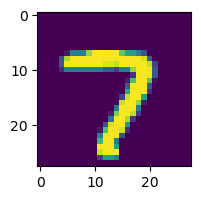

Mismatch for image 523: predicted 8, true label 5


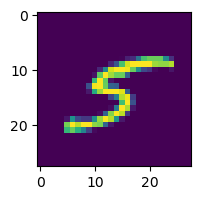

Mismatch for image 524: predicted 8, true label 0


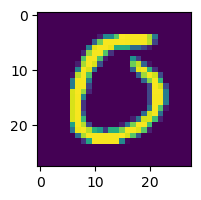

Mismatch for image 525: predicted 8, true label 9


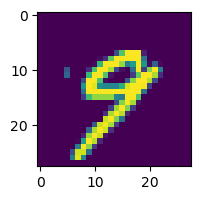

Mismatch for image 526: predicted 8, true label 0


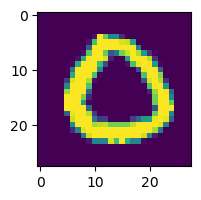

Mismatch for image 527: predicted 8, true label 0


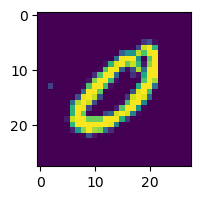

Mismatch for image 529: predicted 8, true label 9


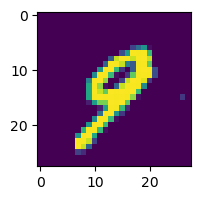

Mismatch for image 530: predicted 8, true label 2


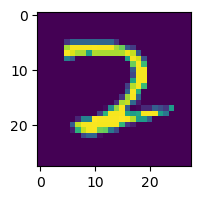

Mismatch for image 531: predicted 8, true label 4


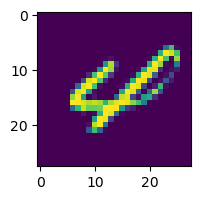

Mismatch for image 533: predicted 8, true label 1


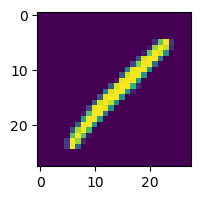

Mismatch for image 534: predicted 8, true label 6


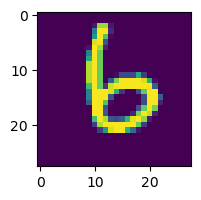

Mismatch for image 535: predicted 8, true label 1


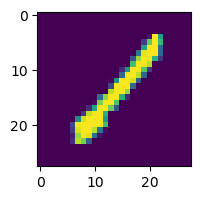

Mismatch for image 536: predicted 8, true label 6


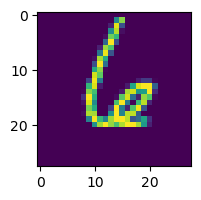

Mismatch for image 537: predicted 8, true label 5


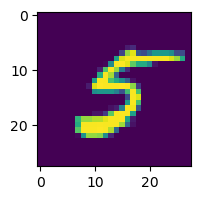

Mismatch for image 538: predicted 8, true label 1


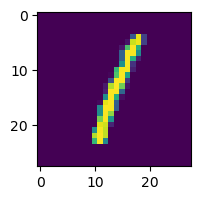

Mismatch for image 540: predicted 8, true label 3


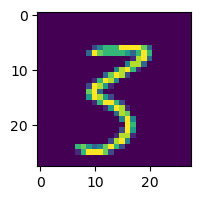

Mismatch for image 541: predicted 8, true label 4


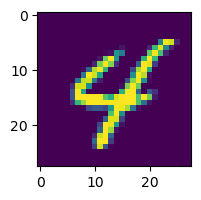

Mismatch for image 542: predicted 8, true label 0


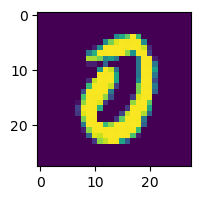

Mismatch for image 543: predicted 8, true label 5


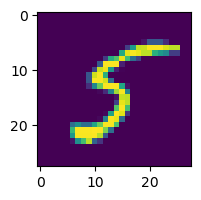

Mismatch for image 544: predicted 8, true label 5


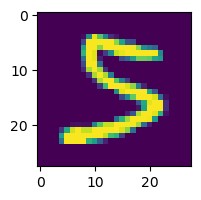

Mismatch for image 546: predicted 8, true label 3


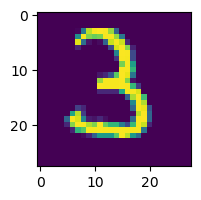

Mismatch for image 547: predicted 8, true label 6


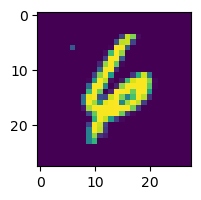

Mismatch for image 548: predicted 8, true label 2


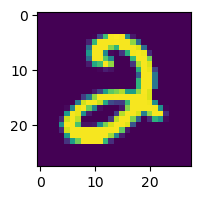

Mismatch for image 549: predicted 8, true label 3


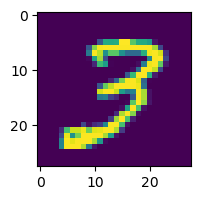

Mismatch for image 550: predicted 8, true label 9


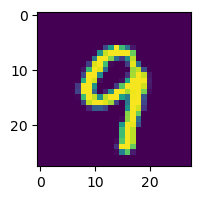

Mismatch for image 551: predicted 8, true label 2


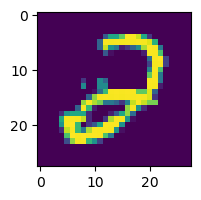

Mismatch for image 552: predicted 8, true label 1


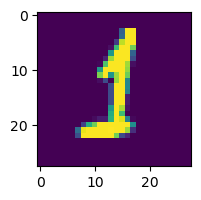

Mismatch for image 553: predicted 8, true label 1


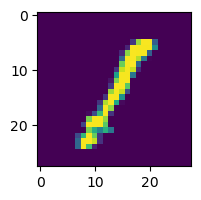

Mismatch for image 554: predicted 8, true label 5


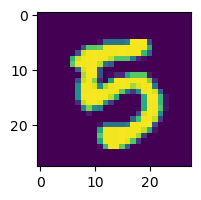

Mismatch for image 555: predicted 8, true label 2


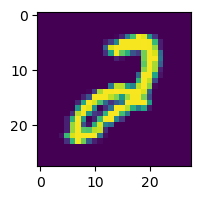

Mismatch for image 556: predicted 8, true label 1


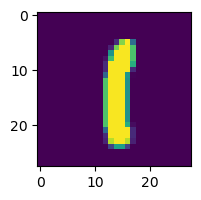

Mismatch for image 557: predicted 8, true label 3


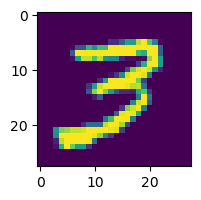

Mismatch for image 558: predicted 8, true label 2


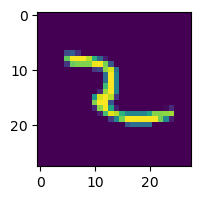

Mismatch for image 560: predicted 8, true label 7


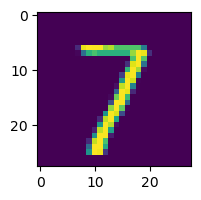

Mismatch for image 561: predicted 8, true label 3


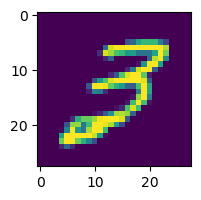

Mismatch for image 562: predicted 8, true label 7


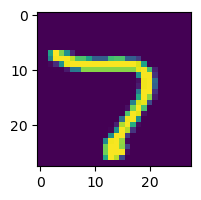

Mismatch for image 563: predicted 8, true label 2


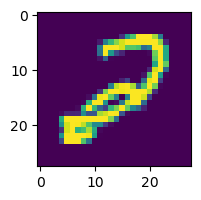

Mismatch for image 564: predicted 8, true label 4


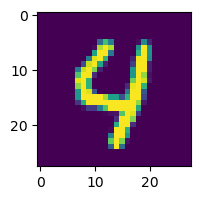

Mismatch for image 565: predicted 8, true label 6


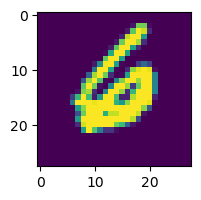

Mismatch for image 566: predicted 8, true label 9


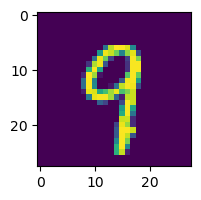

Mismatch for image 567: predicted 8, true label 7


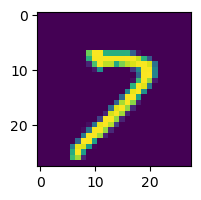

Mismatch for image 568: predicted 8, true label 2


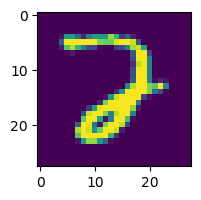

Mismatch for image 569: predicted 8, true label 4


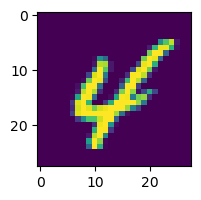

Mismatch for image 570: predicted 8, true label 2


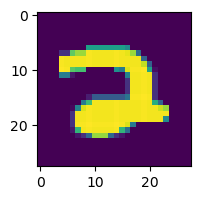

Mismatch for image 572: predicted 8, true label 1


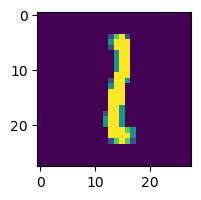

Mismatch for image 573: predicted 8, true label 1


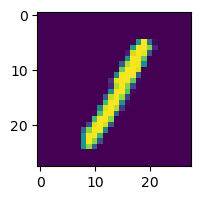

Mismatch for image 574: predicted 8, true label 3


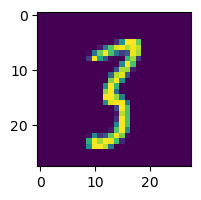

Mismatch for image 576: predicted 8, true label 4


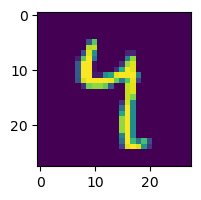

Mismatch for image 577: predicted 8, true label 0


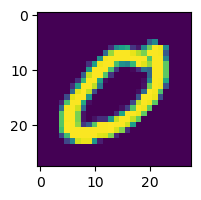

Mismatch for image 578: predicted 8, true label 6


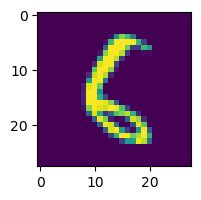

Mismatch for image 579: predicted 8, true label 5


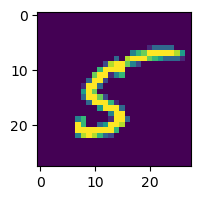

Mismatch for image 580: predicted 8, true label 9


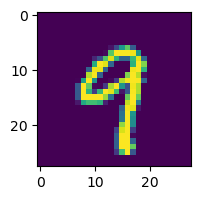

Mismatch for image 581: predicted 8, true label 3


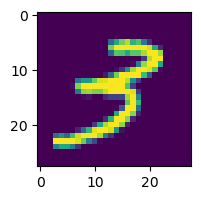

Mismatch for image 582: predicted 8, true label 0


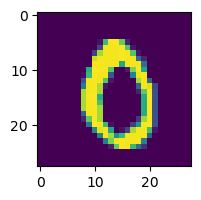

Mismatch for image 583: predicted 8, true label 9


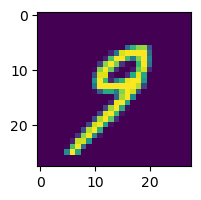

Mismatch for image 584: predicted 8, true label 2


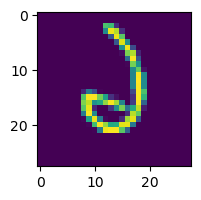

Mismatch for image 585: predicted 8, true label 4


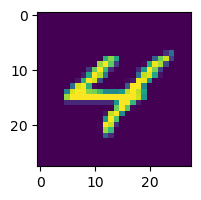

Mismatch for image 586: predicted 8, true label 7


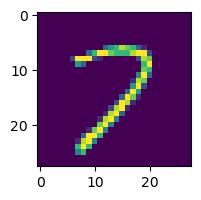

Mismatch for image 587: predicted 8, true label 1


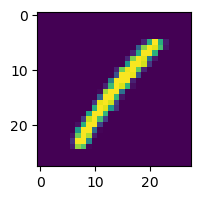

Mismatch for image 588: predicted 8, true label 2


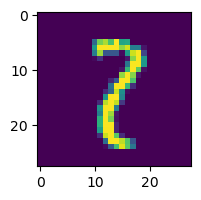

Mismatch for image 589: predicted 8, true label 9


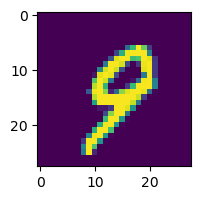

Mismatch for image 590: predicted 8, true label 4


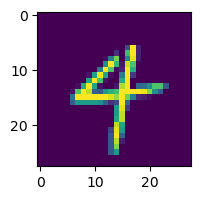

Mismatch for image 591: predicted 8, true label 2


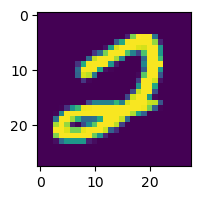

Mismatch for image 592: predicted 8, true label 6


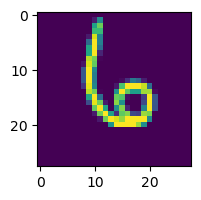

Mismatch for image 593: predicted 8, true label 1


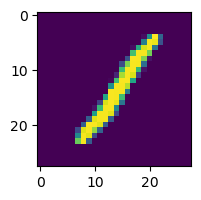

Mismatch for image 595: predicted 8, true label 9


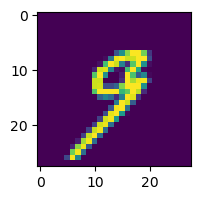

Mismatch for image 596: predicted 8, true label 0


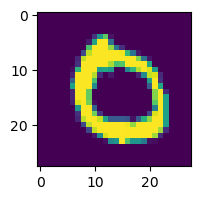

Mismatch for image 597: predicted 8, true label 6


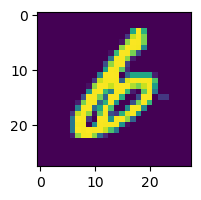

Mismatch for image 598: predicted 8, true label 6


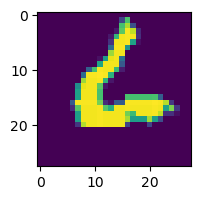

Mismatch for image 599: predicted 8, true label 7


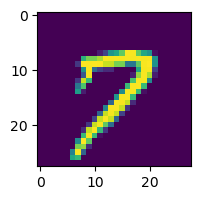

Mismatch for image 600: predicted 8, true label 9


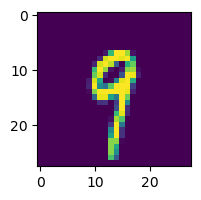

Mismatch for image 601: predicted 8, true label 9


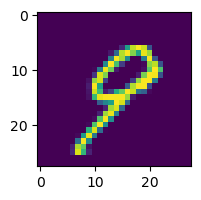

Mismatch for image 603: predicted 8, true label 0


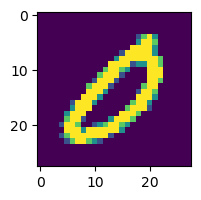

Mismatch for image 604: predicted 8, true label 1


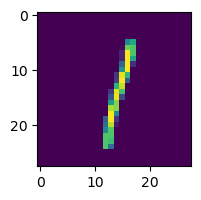

Mismatch for image 605: predicted 8, true label 4


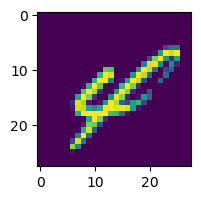

Mismatch for image 606: predicted 8, true label 4


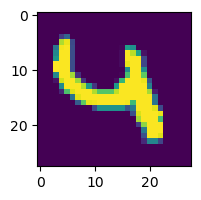

Mismatch for image 607: predicted 8, true label 6


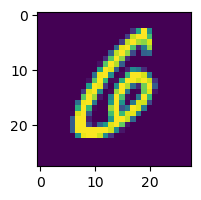

Mismatch for image 608: predicted 8, true label 7


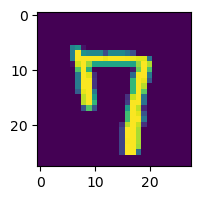

Mismatch for image 609: predicted 8, true label 1


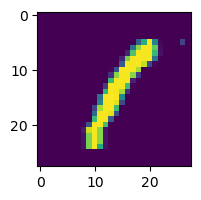

Mismatch for image 610: predicted 8, true label 5


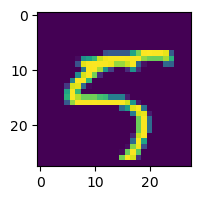

Mismatch for image 611: predicted 8, true label 7


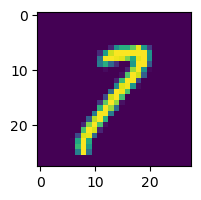

Mismatch for image 612: predicted 8, true label 0


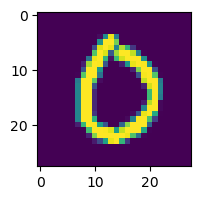

Mismatch for image 613: predicted 8, true label 3


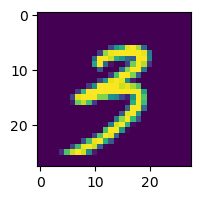

Mismatch for image 614: predicted 8, true label 5


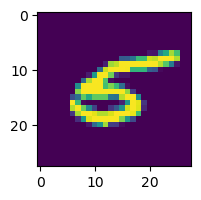

Mismatch for image 616: predicted 8, true label 4


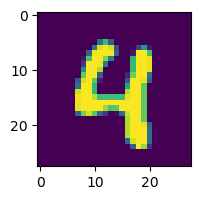

Mismatch for image 617: predicted 8, true label 7


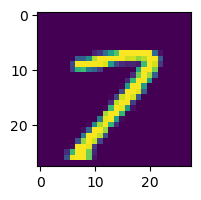

Mismatch for image 618: predicted 8, true label 1


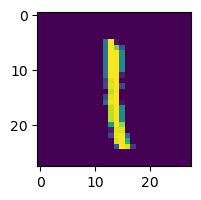

Mismatch for image 619: predicted 8, true label 2


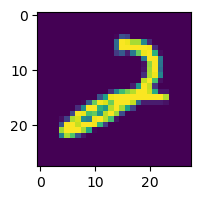

Mismatch for image 620: predicted 8, true label 5


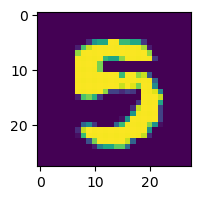

Mismatch for image 621: predicted 8, true label 9


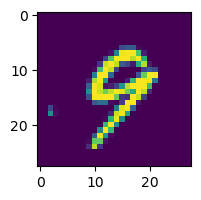

Mismatch for image 622: predicted 8, true label 5


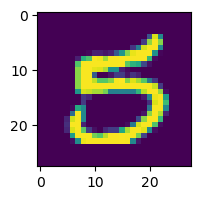

Mismatch for image 623: predicted 8, true label 6


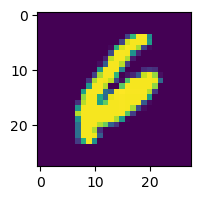

Mismatch for image 624: predicted 8, true label 7


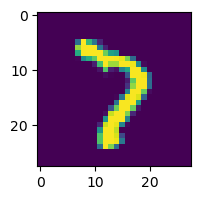

Mismatch for image 625: predicted 8, true label 5


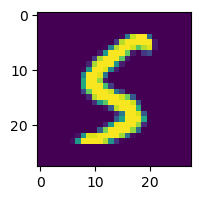

Mismatch for image 626: predicted 8, true label 9


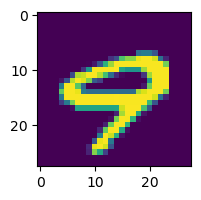

Mismatch for image 629: predicted 8, true label 3


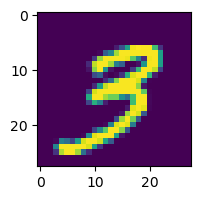

Mismatch for image 630: predicted 8, true label 6


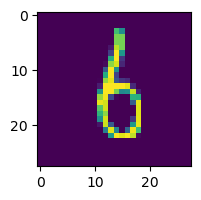

Mismatch for image 631: predicted 8, true label 9


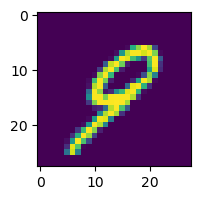

Mismatch for image 632: predicted 8, true label 7


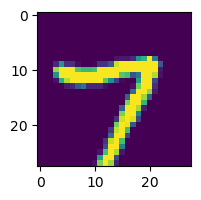

Mismatch for image 633: predicted 8, true label 0


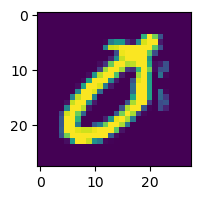

Mismatch for image 634: predicted 8, true label 7


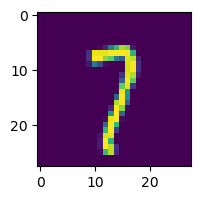

Mismatch for image 635: predicted 8, true label 5


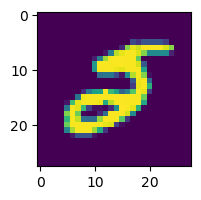

Mismatch for image 636: predicted 8, true label 7


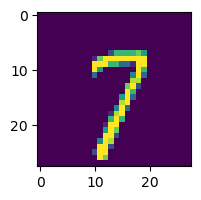

Mismatch for image 637: predicted 8, true label 1


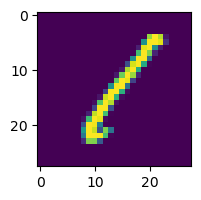

Mismatch for image 638: predicted 8, true label 1


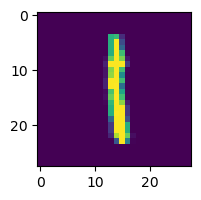

Mismatch for image 639: predicted 8, true label 0


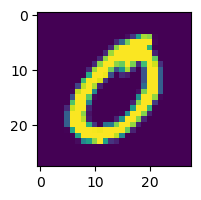

Mismatch for image 640: predicted 8, true label 7


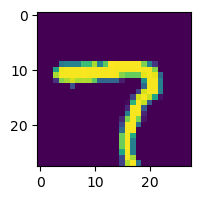

Mismatch for image 641: predicted 8, true label 9


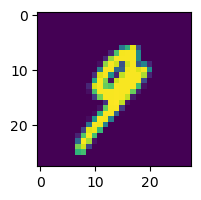

Mismatch for image 642: predicted 8, true label 2


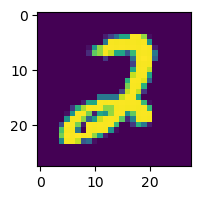

Mismatch for image 643: predicted 8, true label 3


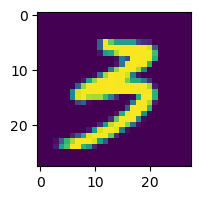

Mismatch for image 644: predicted 8, true label 7


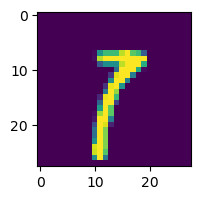

Mismatch for image 645: predicted 8, true label 3


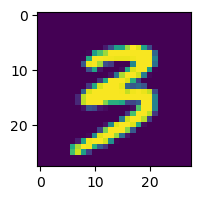

Mismatch for image 646: predicted 8, true label 2


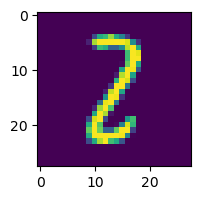

Mismatch for image 647: predicted 8, true label 4


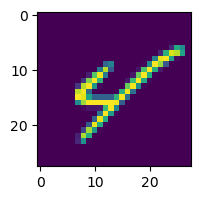

Mismatch for image 648: predicted 8, true label 1


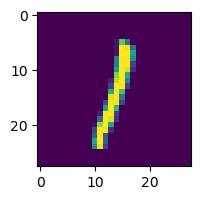

Mismatch for image 649: predicted 8, true label 6


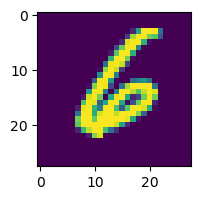

Mismatch for image 650: predicted 8, true label 2


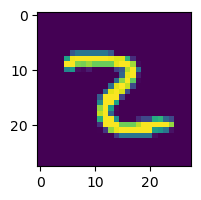

Mismatch for image 651: predicted 8, true label 7


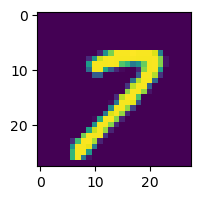

Mismatch for image 652: predicted 8, true label 5


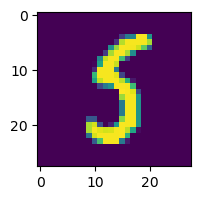

Mismatch for image 653: predicted 8, true label 5


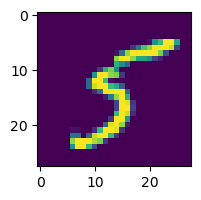

Mismatch for image 654: predicted 8, true label 7


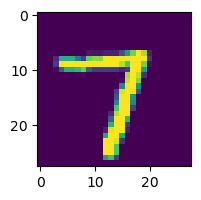

Mismatch for image 655: predicted 8, true label 4


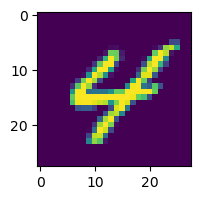

Mismatch for image 656: predicted 8, true label 0


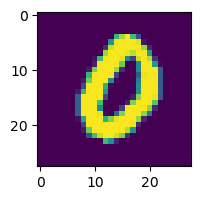

Mismatch for image 657: predicted 8, true label 2


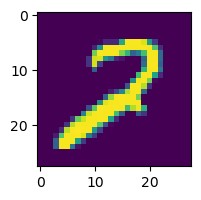

Mismatch for image 658: predicted 8, true label 6


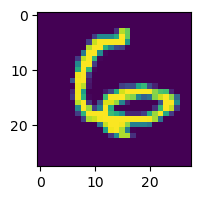

Mismatch for image 659: predicted 8, true label 3


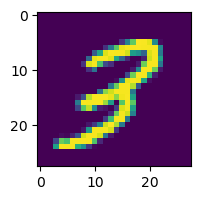

Mismatch for image 660: predicted 8, true label 6


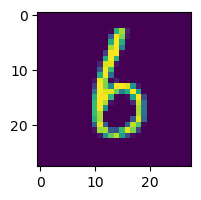

Mismatch for image 661: predicted 8, true label 4


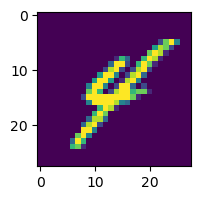

Mismatch for image 662: predicted 8, true label 0


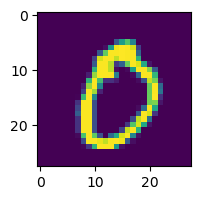

Mismatch for image 663: predicted 8, true label 4


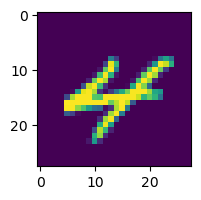

Mismatch for image 664: predicted 8, true label 2


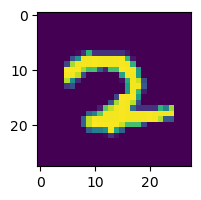

Mismatch for image 665: predicted 8, true label 6


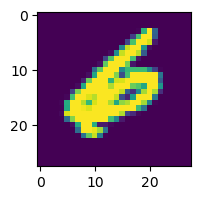

Mismatch for image 666: predicted 8, true label 0


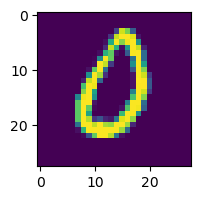

Mismatch for image 667: predicted 8, true label 0


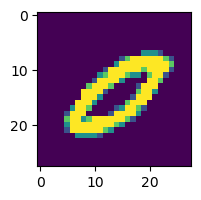

Mismatch for image 668: predicted 8, true label 0


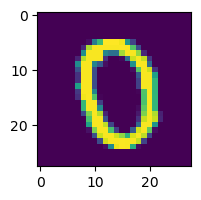

Mismatch for image 669: predicted 8, true label 0


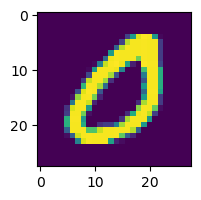

Mismatch for image 670: predicted 8, true label 3


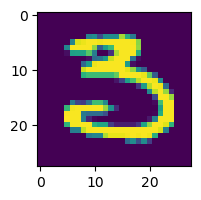

Mismatch for image 671: predicted 8, true label 1


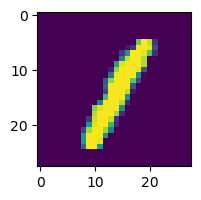

Mismatch for image 672: predicted 8, true label 6


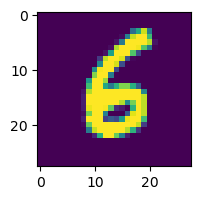

Mismatch for image 673: predicted 8, true label 2


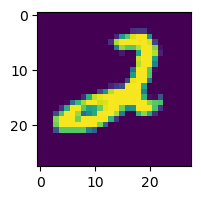

Mismatch for image 674: predicted 8, true label 2


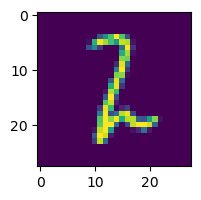

Mismatch for image 675: predicted 8, true label 3


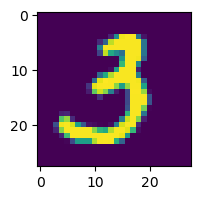

Mismatch for image 676: predicted 8, true label 1


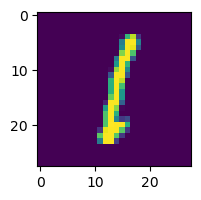

Mismatch for image 677: predicted 8, true label 4


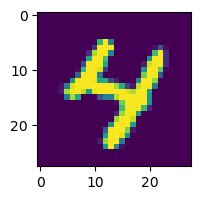

Mismatch for image 678: predicted 8, true label 1


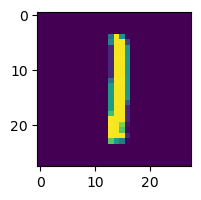

Mismatch for image 679: predicted 8, true label 5


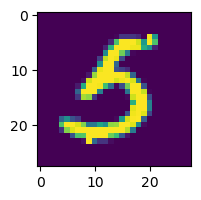

Mismatch for image 680: predicted 8, true label 4


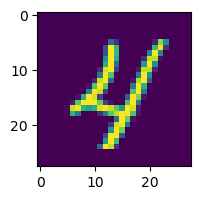

Mismatch for image 681: predicted 8, true label 6


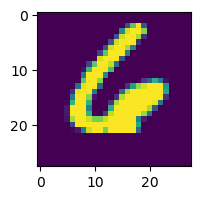

Mismatch for image 682: predicted 8, true label 4


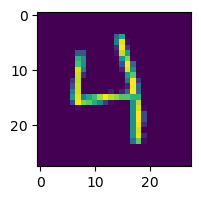

Mismatch for image 683: predicted 8, true label 7


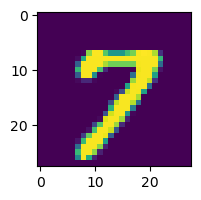

Mismatch for image 684: predicted 8, true label 2


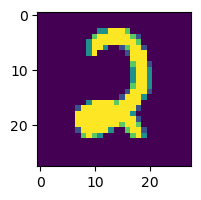

Mismatch for image 686: predicted 8, true label 7


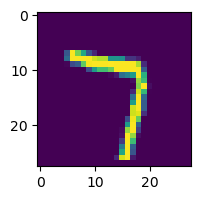

Mismatch for image 687: predicted 8, true label 9


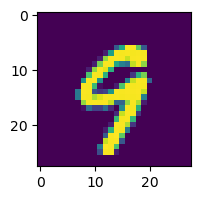

Mismatch for image 688: predicted 8, true label 2


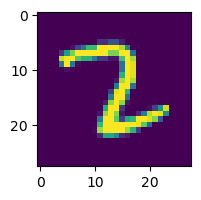

Mismatch for image 689: predicted 8, true label 0


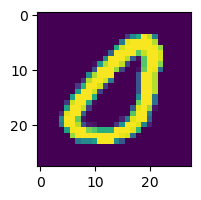

Mismatch for image 690: predicted 8, true label 5


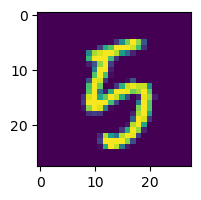

Mismatch for image 691: predicted 8, true label 1


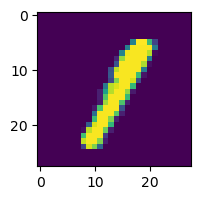

Mismatch for image 692: predicted 8, true label 4


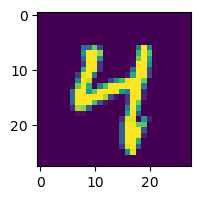

Mismatch for image 693: predicted 8, true label 2


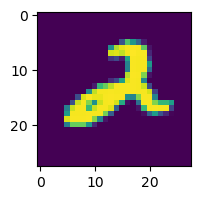

Mismatch for image 695: predicted 8, true label 3


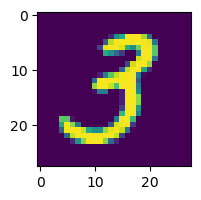

Mismatch for image 696: predicted 8, true label 2


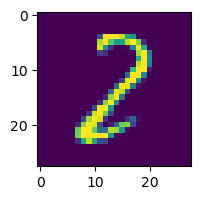

Mismatch for image 697: predicted 8, true label 4


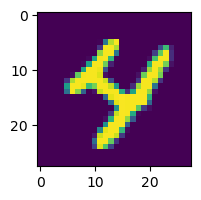

Mismatch for image 698: predicted 8, true label 1


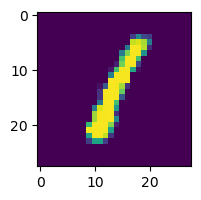

Mismatch for image 699: predicted 8, true label 5


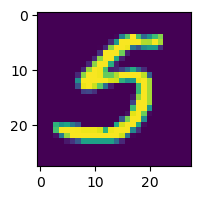

Mismatch for image 700: predicted 8, true label 4


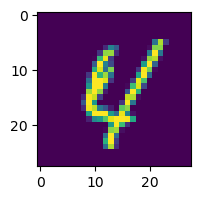

Mismatch for image 701: predicted 8, true label 6


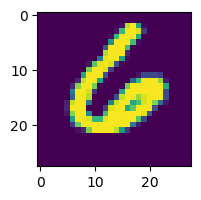

Mismatch for image 702: predicted 8, true label 0


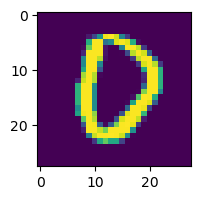

Mismatch for image 703: predicted 8, true label 7


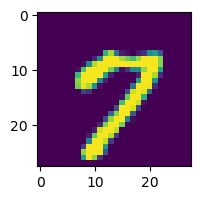

Mismatch for image 704: predicted 8, true label 9


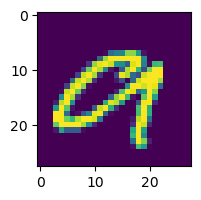

Mismatch for image 706: predicted 8, true label 4


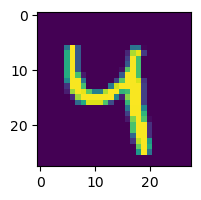

Mismatch for image 707: predicted 8, true label 9


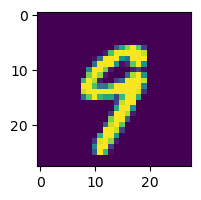

Mismatch for image 709: predicted 8, true label 0


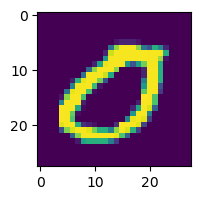

Mismatch for image 710: predicted 8, true label 1


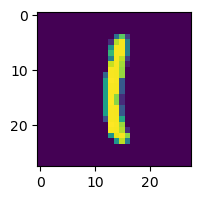

Mismatch for image 711: predicted 8, true label 1


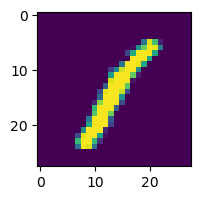

Mismatch for image 712: predicted 8, true label 0


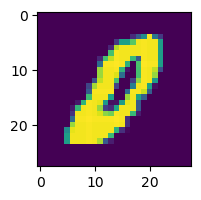

Mismatch for image 713: predicted 8, true label 2


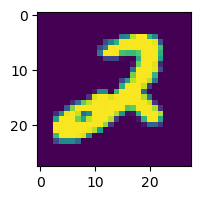

Mismatch for image 714: predicted 8, true label 2


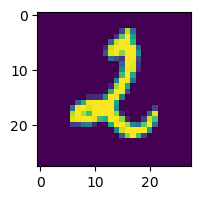

Mismatch for image 715: predicted 8, true label 3


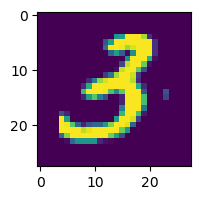

Mismatch for image 716: predicted 8, true label 2


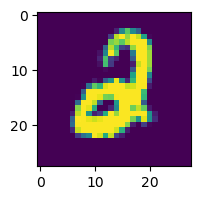

Mismatch for image 717: predicted 8, true label 4


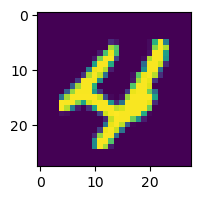

Mismatch for image 718: predicted 8, true label 4


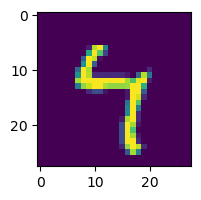

Mismatch for image 719: predicted 8, true label 5


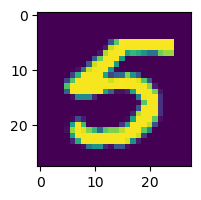

Mismatch for image 721: predicted 8, true label 6


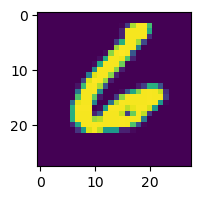

Mismatch for image 722: predicted 8, true label 5


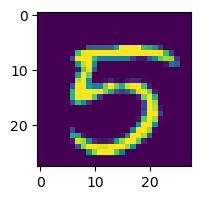

Mismatch for image 723: predicted 8, true label 7


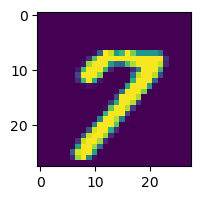

Mismatch for image 724: predicted 8, true label 7


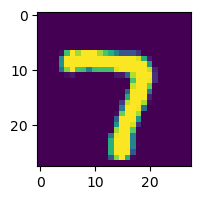

Mismatch for image 727: predicted 8, true label 9


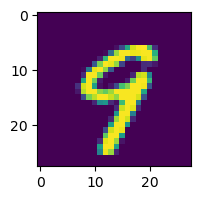

Mismatch for image 728: predicted 8, true label 7


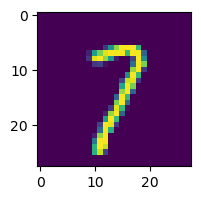

Mismatch for image 729: predicted 8, true label 4


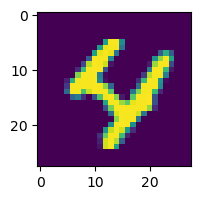

Mismatch for image 730: predicted 8, true label 7


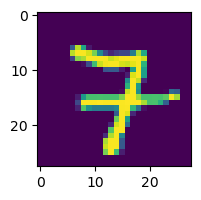

Mismatch for image 731: predicted 8, true label 3


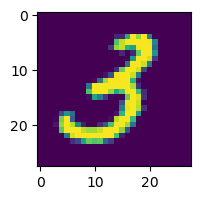

Mismatch for image 732: predicted 8, true label 2


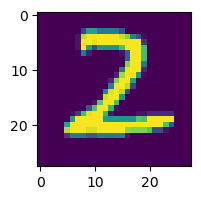

Mismatch for image 733: predicted 8, true label 0


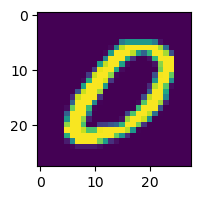

Mismatch for image 735: predicted 8, true label 6


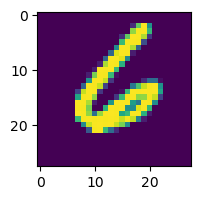

Mismatch for image 737: predicted 8, true label 6


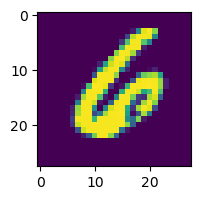

Mismatch for image 738: predicted 8, true label 1


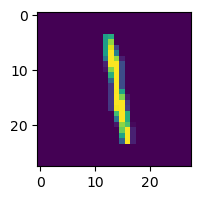

Mismatch for image 739: predicted 8, true label 6


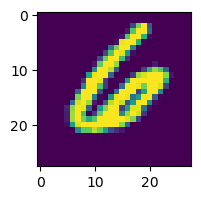

Mismatch for image 741: predicted 8, true label 9


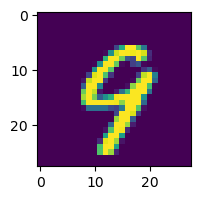

Mismatch for image 742: predicted 8, true label 4


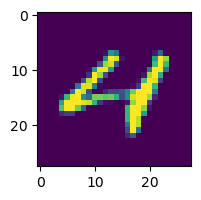

Mismatch for image 743: predicted 8, true label 0


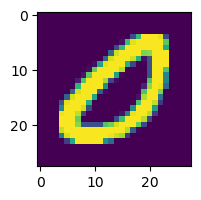

Mismatch for image 744: predicted 8, true label 9


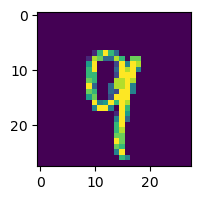

Mismatch for image 745: predicted 8, true label 0


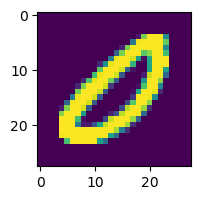

Mismatch for image 746: predicted 8, true label 4


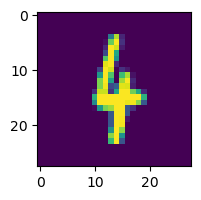

Mismatch for image 747: predicted 8, true label 1


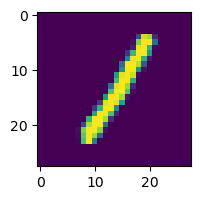

Mismatch for image 748: predicted 8, true label 5


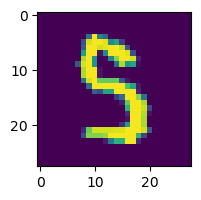

Mismatch for image 749: predicted 8, true label 4


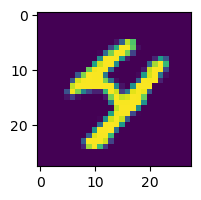

Mismatch for image 750: predicted 8, true label 7


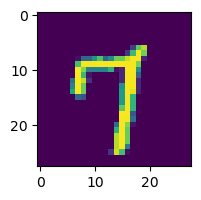

Mismatch for image 751: predicted 8, true label 5


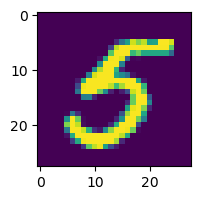

Mismatch for image 752: predicted 8, true label 3


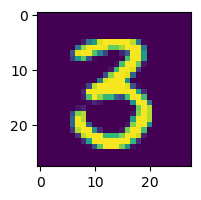

Mismatch for image 753: predicted 8, true label 7


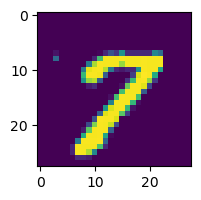

Mismatch for image 754: predicted 8, true label 4


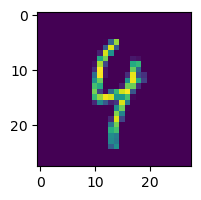

Mismatch for image 755: predicted 8, true label 9


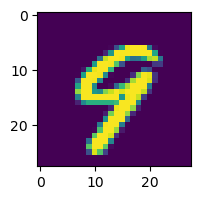

Mismatch for image 757: predicted 8, true label 5


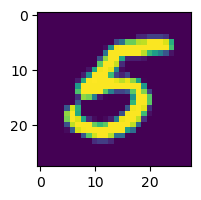

Mismatch for image 759: predicted 8, true label 6


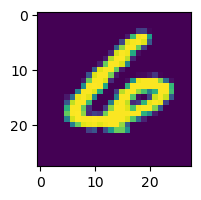

Mismatch for image 760: predicted 8, true label 3


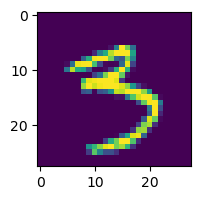

Mismatch for image 762: predicted 8, true label 6


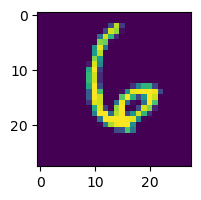

Mismatch for image 763: predicted 8, true label 9


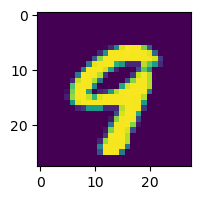

Mismatch for image 764: predicted 8, true label 9


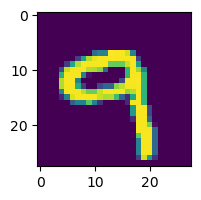

Mismatch for image 765: predicted 8, true label 1


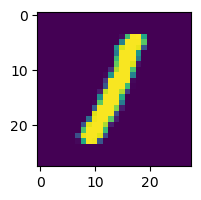

Mismatch for image 767: predicted 8, true label 3


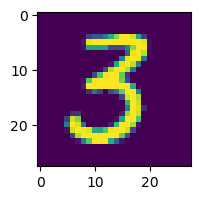

Mismatch for image 768: predicted 8, true label 5


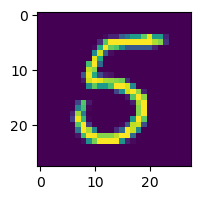

Mismatch for image 770: predicted 8, true label 6


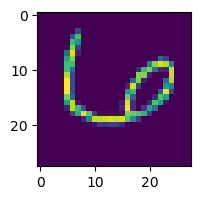

Mismatch for image 771: predicted 8, true label 5


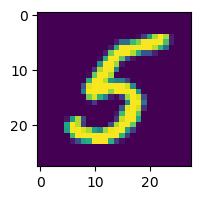

Mismatch for image 772: predicted 8, true label 9


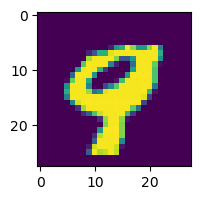

Mismatch for image 773: predicted 8, true label 7


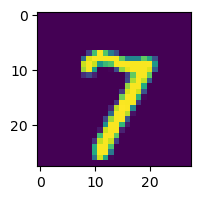

Mismatch for image 774: predicted 8, true label 2


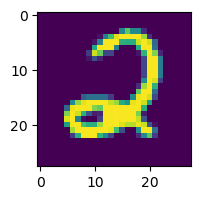

Mismatch for image 775: predicted 8, true label 5


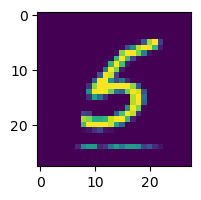

Mismatch for image 776: predicted 8, true label 0


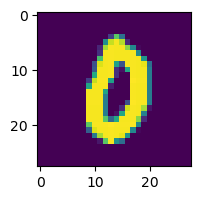

Mismatch for image 778: predicted 8, true label 5


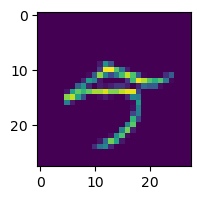

Mismatch for image 779: predicted 8, true label 1


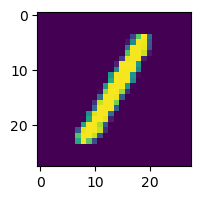

Mismatch for image 780: predicted 8, true label 1


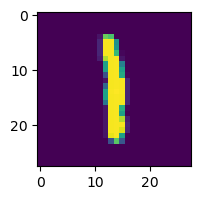

Mismatch for image 781: predicted 8, true label 0


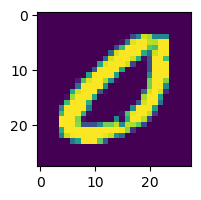

Mismatch for image 782: predicted 8, true label 9


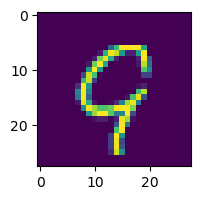

Mismatch for image 783: predicted 8, true label 1


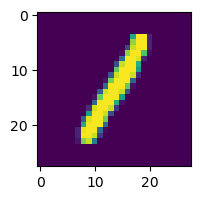

Mismatch for image 785: predicted 8, true label 6


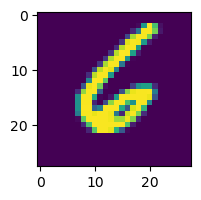

Mismatch for image 786: predicted 8, true label 7


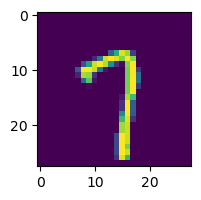

Mismatch for image 787: predicted 8, true label 0


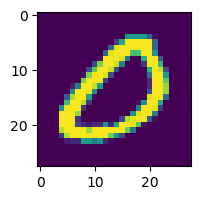

Mismatch for image 788: predicted 8, true label 9


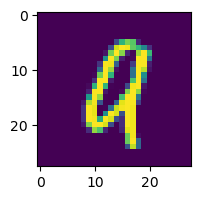

Mismatch for image 789: predicted 8, true label 3


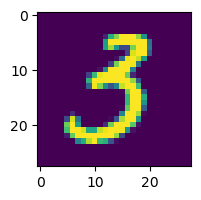

Mismatch for image 790: predicted 8, true label 0


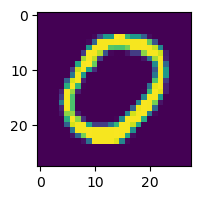

Mismatch for image 793: predicted 8, true label 9


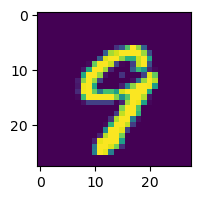

Mismatch for image 794: predicted 8, true label 6


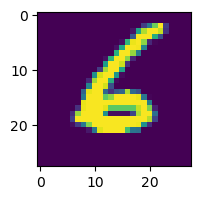

Mismatch for image 795: predicted 8, true label 7


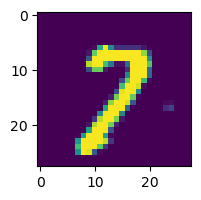

Mismatch for image 797: predicted 8, true label 4


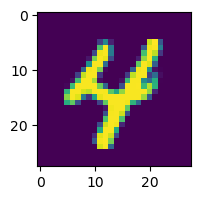

Mismatch for image 798: predicted 8, true label 7


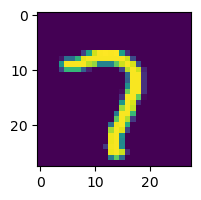

Mismatch for image 799: predicted 8, true label 5


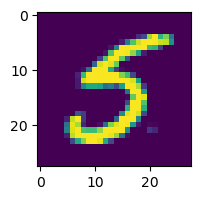

Mismatch for image 800: predicted 8, true label 9


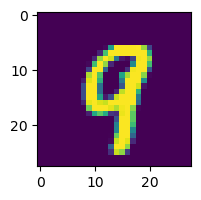

Mismatch for image 801: predicted 8, true label 2


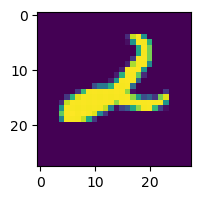

Mismatch for image 802: predicted 8, true label 6


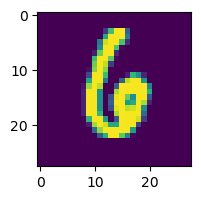

Mismatch for image 803: predicted 8, true label 7


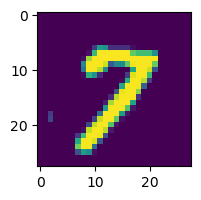

Mismatch for image 804: predicted 8, true label 4


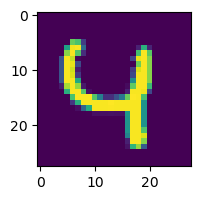

Mismatch for image 805: predicted 8, true label 5


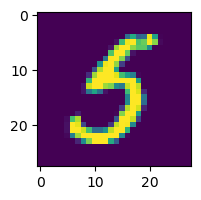

Mismatch for image 806: predicted 8, true label 9


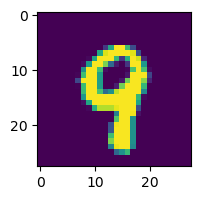

Mismatch for image 807: predicted 8, true label 2


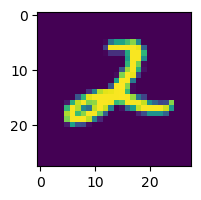

Mismatch for image 808: predicted 8, true label 3


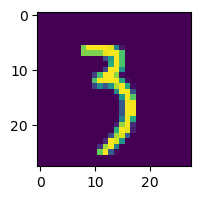

Mismatch for image 809: predicted 8, true label 1


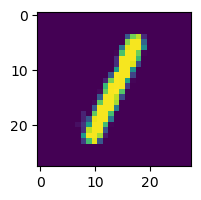

Mismatch for image 810: predicted 8, true label 6


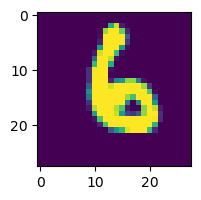

Mismatch for image 811: predicted 8, true label 3


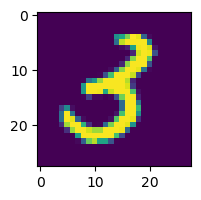

Mismatch for image 812: predicted 8, true label 9


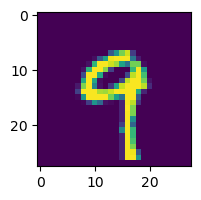

Mismatch for image 813: predicted 8, true label 2


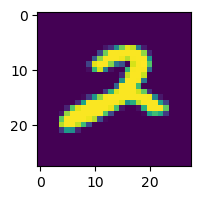

Mismatch for image 814: predicted 8, true label 2


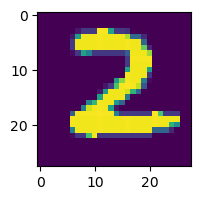

Mismatch for image 815: predicted 8, true label 5


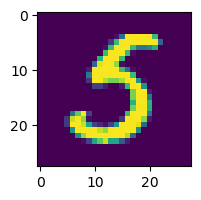

Mismatch for image 816: predicted 8, true label 6


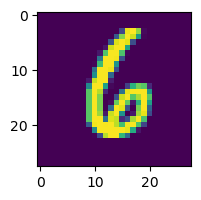

Mismatch for image 818: predicted 8, true label 0


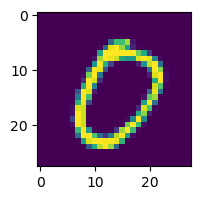

Mismatch for image 819: predicted 8, true label 7


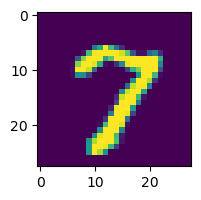

Mismatch for image 820: predicted 8, true label 7


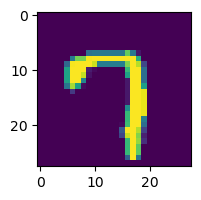

Mismatch for image 821: predicted 8, true label 1


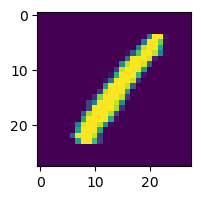

Mismatch for image 822: predicted 8, true label 9


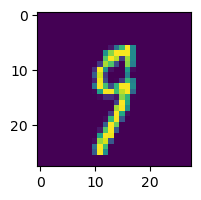

Mismatch for image 824: predicted 8, true label 7


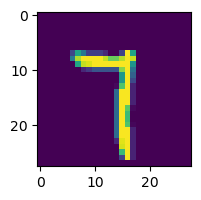

Mismatch for image 825: predicted 8, true label 0


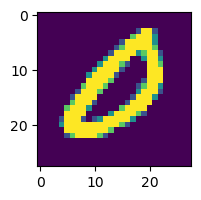

Mismatch for image 826: predicted 8, true label 9


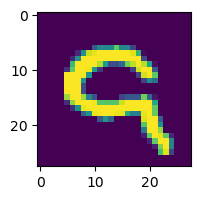

Mismatch for image 827: predicted 8, true label 9


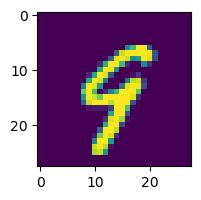

Mismatch for image 828: predicted 8, true label 4


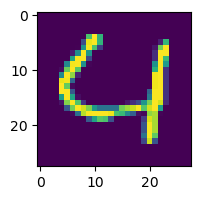

Mismatch for image 829: predicted 8, true label 6


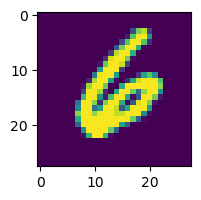

Mismatch for image 830: predicted 8, true label 2


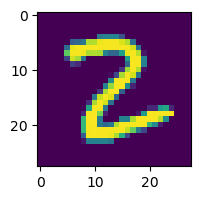

Mismatch for image 832: predicted 8, true label 5


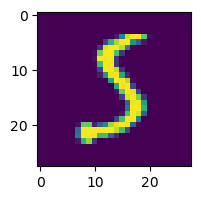

Mismatch for image 833: predicted 8, true label 1


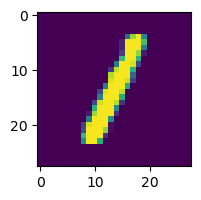

Mismatch for image 834: predicted 8, true label 4


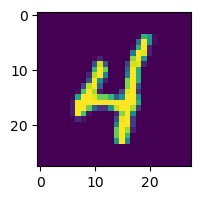

Mismatch for image 835: predicted 8, true label 1


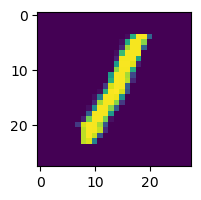

Mismatch for image 836: predicted 8, true label 5


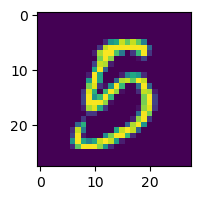

Mismatch for image 837: predicted 8, true label 5


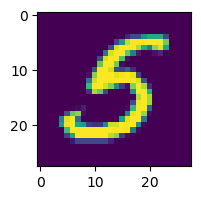

Mismatch for image 838: predicted 8, true label 1


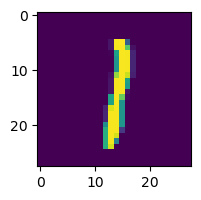

Mismatch for image 839: predicted 8, true label 7


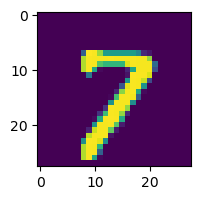

Mismatch for image 840: predicted 8, true label 3


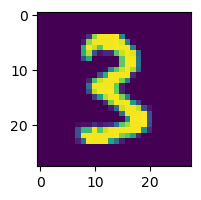

Mismatch for image 841: predicted 8, true label 6


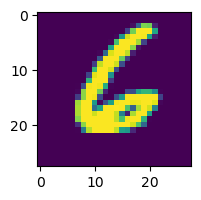

Mismatch for image 842: predicted 8, true label 4


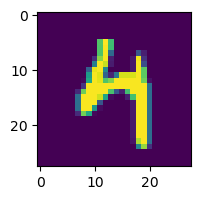

Mismatch for image 843: predicted 8, true label 3


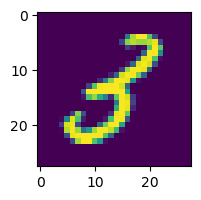

Mismatch for image 844: predicted 8, true label 2


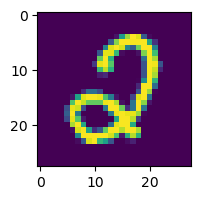

Mismatch for image 845: predicted 8, true label 5


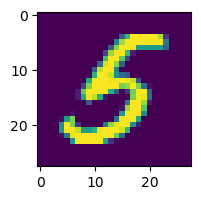

Mismatch for image 846: predicted 8, true label 6


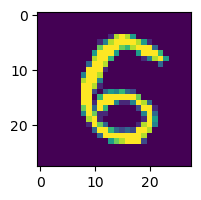

Mismatch for image 847: predicted 8, true label 4


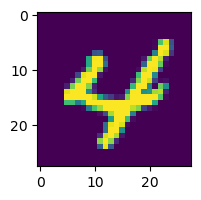

Mismatch for image 848: predicted 8, true label 4


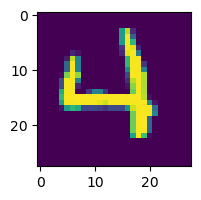

Mismatch for image 849: predicted 8, true label 0


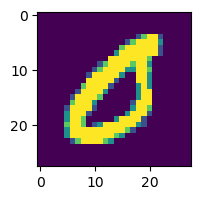

Mismatch for image 850: predicted 8, true label 4


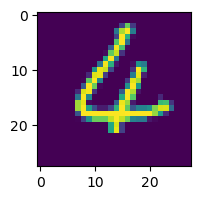

Mismatch for image 851: predicted 8, true label 4


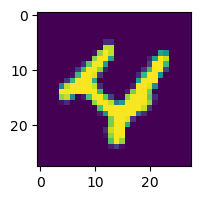

Mismatch for image 852: predicted 8, true label 6


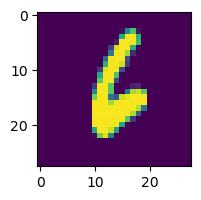

Mismatch for image 853: predicted 8, true label 7


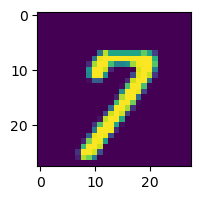

Mismatch for image 854: predicted 8, true label 2


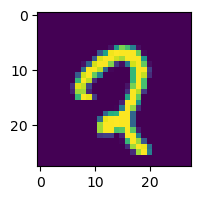

Mismatch for image 855: predicted 8, true label 4


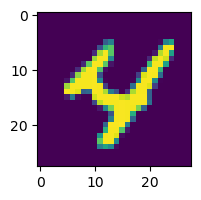

Mismatch for image 856: predicted 8, true label 3


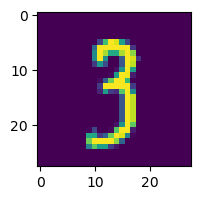

Mismatch for image 857: predicted 8, true label 3


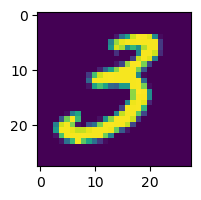

Mismatch for image 859: predicted 8, true label 0


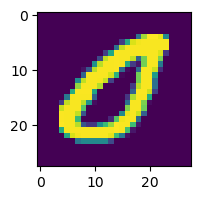

Mismatch for image 860: predicted 8, true label 0


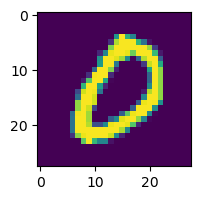

Mismatch for image 861: predicted 8, true label 3


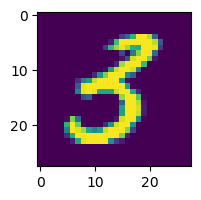

Mismatch for image 862: predicted 8, true label 2


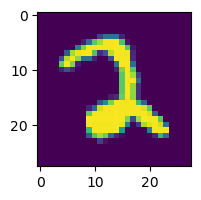

Mismatch for image 863: predicted 8, true label 2


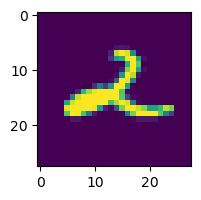

Mismatch for image 864: predicted 8, true label 9


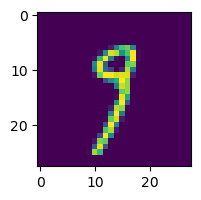

Mismatch for image 866: predicted 8, true label 2


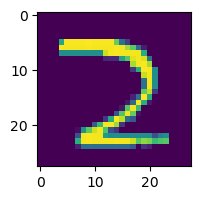

Mismatch for image 867: predicted 8, true label 3


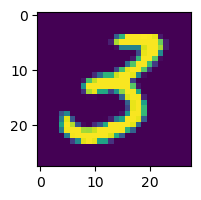

Mismatch for image 868: predicted 8, true label 7


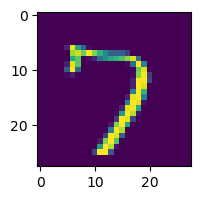

Mismatch for image 869: predicted 8, true label 0


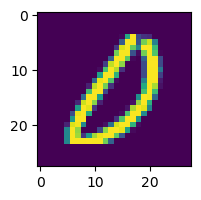

Mismatch for image 870: predicted 8, true label 1


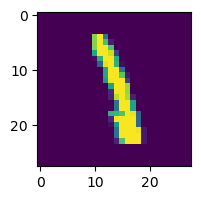

Mismatch for image 871: predicted 8, true label 1


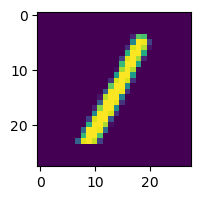

Mismatch for image 872: predicted 8, true label 0


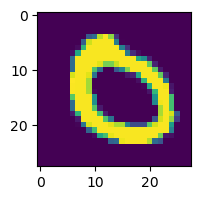

Mismatch for image 873: predicted 8, true label 2


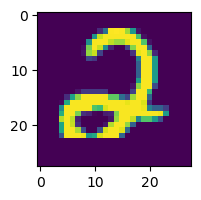

Mismatch for image 874: predicted 8, true label 3


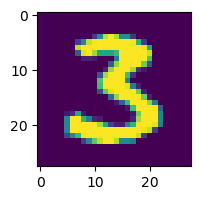

Mismatch for image 875: predicted 8, true label 3


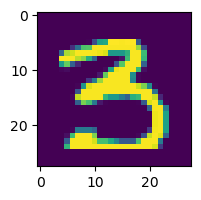

Mismatch for image 877: predicted 8, true label 4


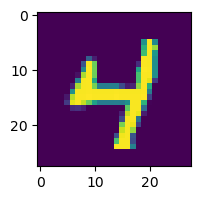

Mismatch for image 878: predicted 8, true label 3


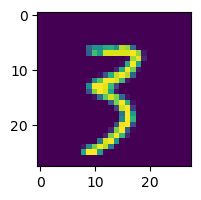

Mismatch for image 879: predicted 8, true label 5


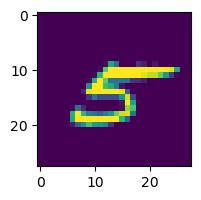

Mismatch for image 880: predicted 8, true label 7


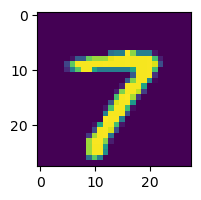

Mismatch for image 881: predicted 8, true label 6


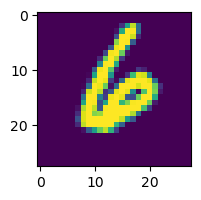

Mismatch for image 882: predicted 8, true label 4


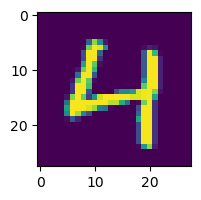

Mismatch for image 883: predicted 8, true label 7


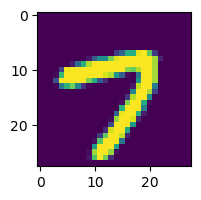

Mismatch for image 884: predicted 8, true label 7


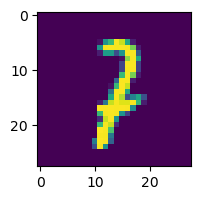

Mismatch for image 886: predicted 8, true label 5


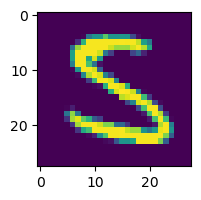

Mismatch for image 887: predicted 8, true label 9


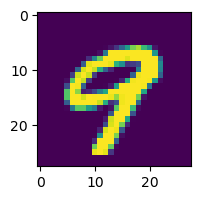

Mismatch for image 888: predicted 8, true label 7


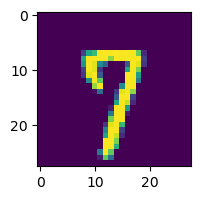

Mismatch for image 889: predicted 8, true label 0


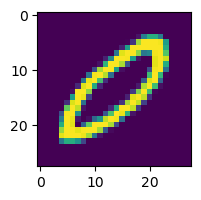

Mismatch for image 890: predicted 8, true label 3


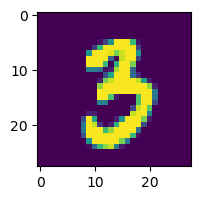

Mismatch for image 891: predicted 8, true label 1


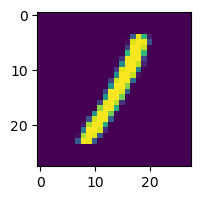

Mismatch for image 892: predicted 8, true label 6


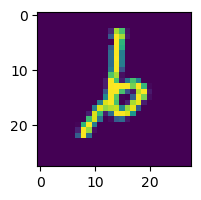

Mismatch for image 893: predicted 8, true label 2


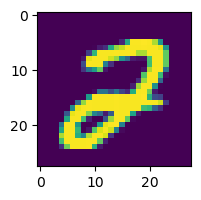

Mismatch for image 894: predicted 8, true label 4


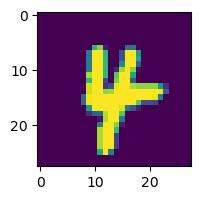

Mismatch for image 895: predicted 8, true label 3


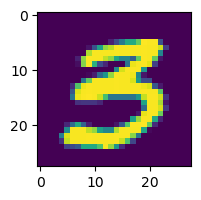

Mismatch for image 896: predicted 8, true label 4


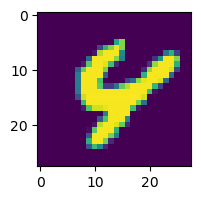

Mismatch for image 897: predicted 8, true label 4


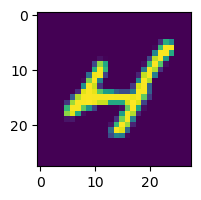

Mismatch for image 898: predicted 8, true label 7


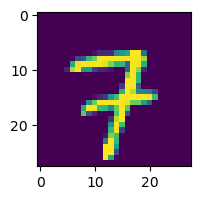

Mismatch for image 899: predicted 8, true label 5


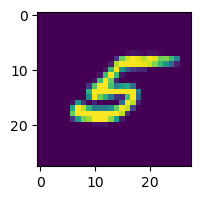

Mismatch for image 900: predicted 8, true label 9


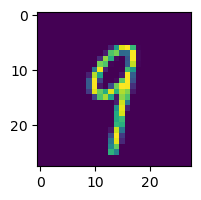

Mismatch for image 901: predicted 8, true label 6


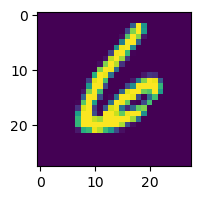

Mismatch for image 902: predicted 8, true label 9


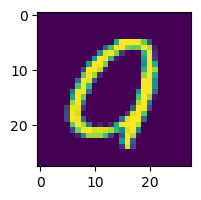

Mismatch for image 903: predicted 8, true label 0


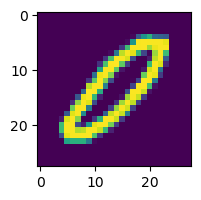

Mismatch for image 904: predicted 8, true label 7


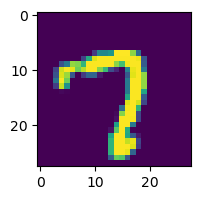

Mismatch for image 905: predicted 8, true label 1


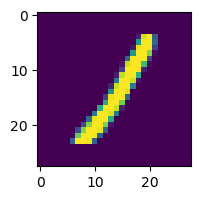

Mismatch for image 906: predicted 8, true label 4


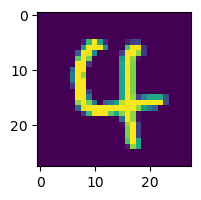

Mismatch for image 907: predicted 8, true label 2


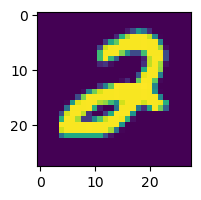

Mismatch for image 908: predicted 8, true label 7


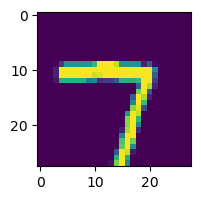

Mismatch for image 909: predicted 8, true label 3


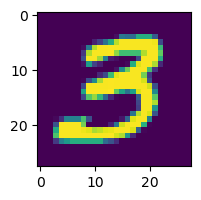

Mismatch for image 910: predicted 8, true label 6


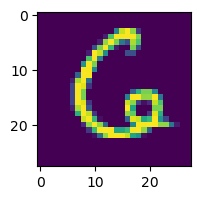

Mismatch for image 911: predicted 8, true label 7


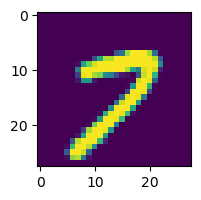

Mismatch for image 912: predicted 8, true label 5


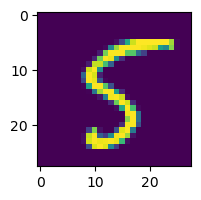

Mismatch for image 914: predicted 8, true label 4


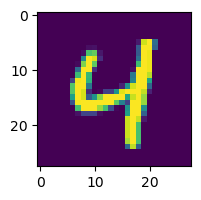

Mismatch for image 915: predicted 8, true label 5


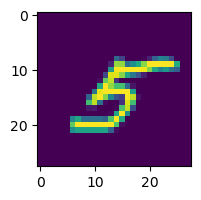

Mismatch for image 916: predicted 8, true label 5


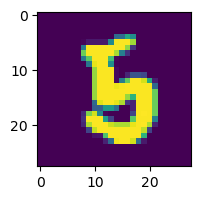

Mismatch for image 917: predicted 8, true label 2


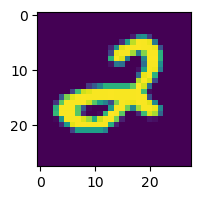

Mismatch for image 918: predicted 8, true label 7


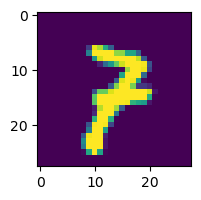

Mismatch for image 919: predicted 8, true label 1


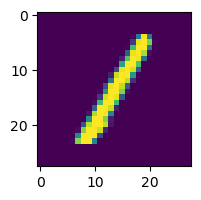

Mismatch for image 920: predicted 8, true label 1


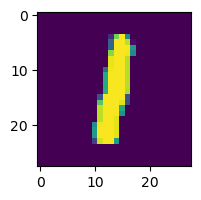

Mismatch for image 921: predicted 8, true label 5


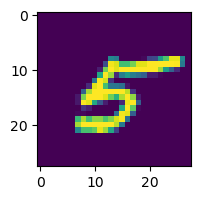

Mismatch for image 922: predicted 8, true label 6


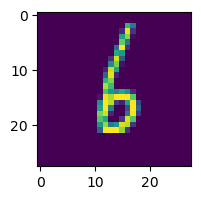

Mismatch for image 924: predicted 8, true label 5


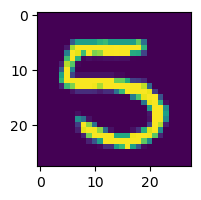

Mismatch for image 926: predicted 8, true label 4


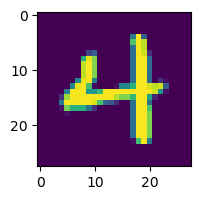

Mismatch for image 927: predicted 8, true label 0


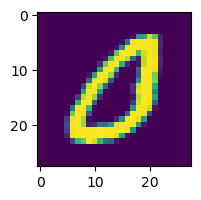

Mismatch for image 928: predicted 8, true label 7


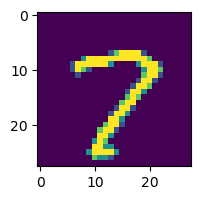

Mismatch for image 929: predicted 8, true label 9


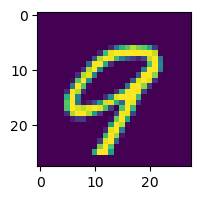

Mismatch for image 930: predicted 8, true label 9


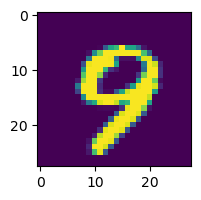

Mismatch for image 931: predicted 8, true label 2


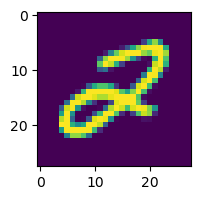

Mismatch for image 932: predicted 8, true label 9


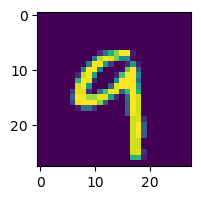

Mismatch for image 933: predicted 8, true label 7


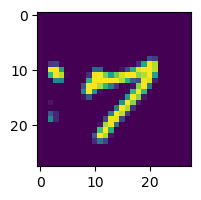

Mismatch for image 934: predicted 8, true label 7


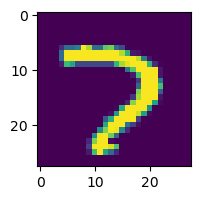

Mismatch for image 936: predicted 8, true label 7


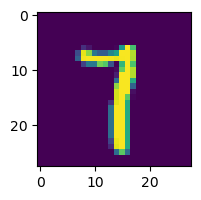

Mismatch for image 937: predicted 8, true label 4


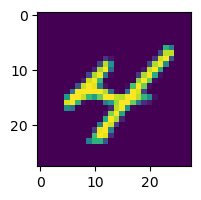

Mismatch for image 938: predicted 8, true label 2


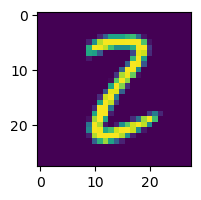

Mismatch for image 939: predicted 8, true label 6


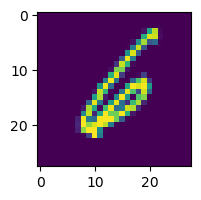

Mismatch for image 940: predicted 8, true label 9


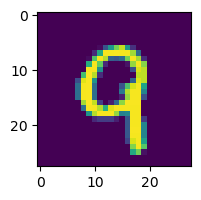

Mismatch for image 941: predicted 8, true label 1


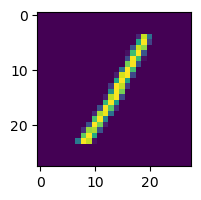

Mismatch for image 942: predicted 8, true label 7


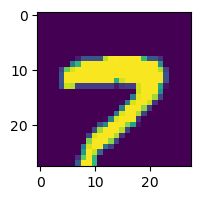

Mismatch for image 943: predicted 8, true label 0


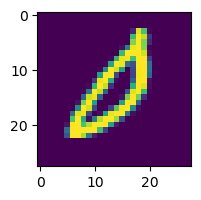

Mismatch for image 944: predicted 8, true label 6


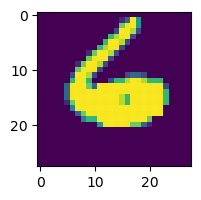

Mismatch for image 945: predicted 8, true label 4


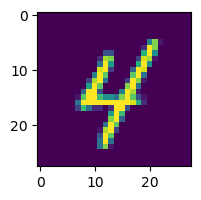

Mismatch for image 946: predicted 8, true label 2


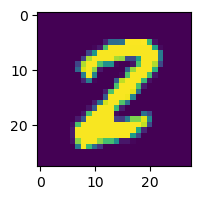

Mismatch for image 947: predicted 8, true label 5


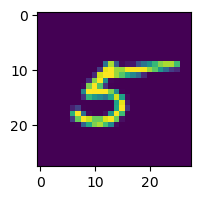

Mismatch for image 948: predicted 8, true label 7


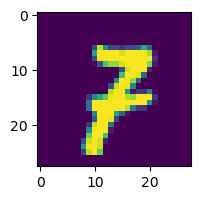

Mismatch for image 949: predicted 8, true label 0


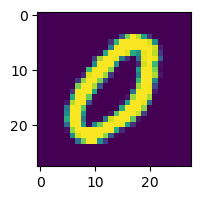

Mismatch for image 950: predicted 8, true label 7


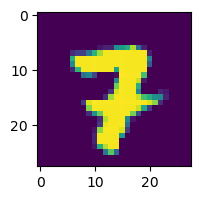

Mismatch for image 951: predicted 8, true label 1


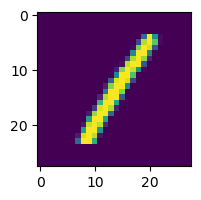

Mismatch for image 952: predicted 8, true label 0


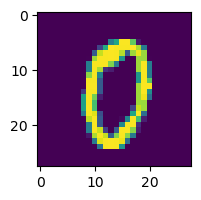

Mismatch for image 953: predicted 8, true label 3


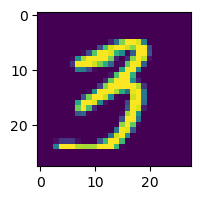

Mismatch for image 954: predicted 8, true label 7


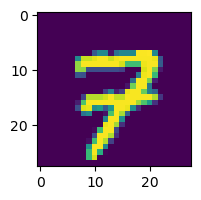

Mismatch for image 955: predicted 8, true label 6


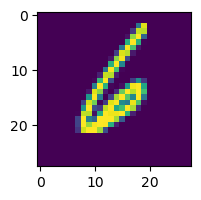

Mismatch for image 956: predicted 8, true label 5


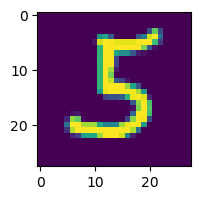

Mismatch for image 957: predicted 8, true label 0


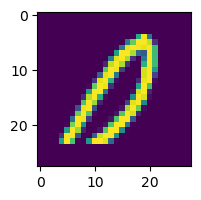

Mismatch for image 958: predicted 8, true label 6


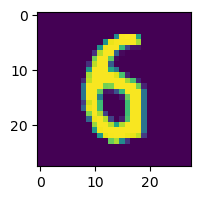

Mismatch for image 959: predicted 8, true label 1


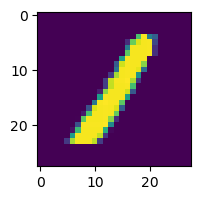

Mismatch for image 960: predicted 8, true label 5


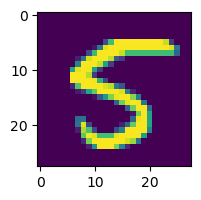

Mismatch for image 961: predicted 8, true label 1


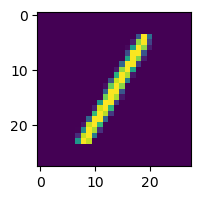

Mismatch for image 962: predicted 8, true label 7


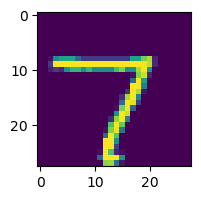

Mismatch for image 964: predicted 8, true label 5


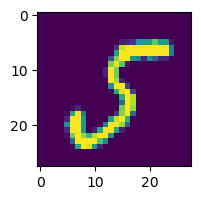

Mismatch for image 965: predicted 8, true label 0


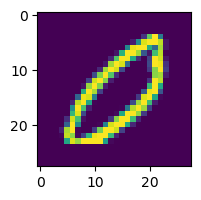

Mismatch for image 966: predicted 8, true label 3


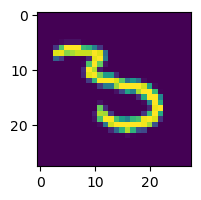

Mismatch for image 967: predicted 8, true label 4


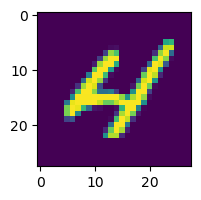

Mismatch for image 968: predicted 8, true label 7


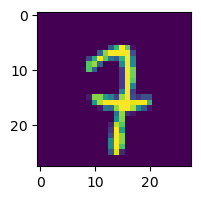

Mismatch for image 969: predicted 8, true label 7


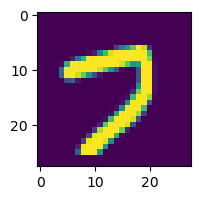

Mismatch for image 970: predicted 8, true label 5


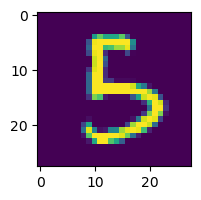

Mismatch for image 971: predicted 8, true label 7


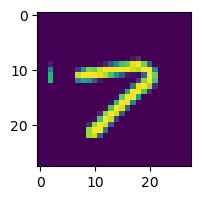

Mismatch for image 973: predicted 8, true label 6


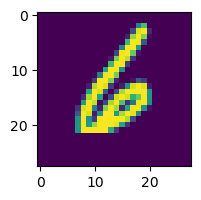

Mismatch for image 974: predicted 8, true label 9


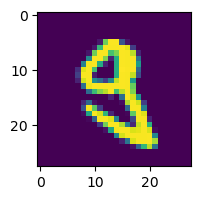

Mismatch for image 975: predicted 8, true label 3


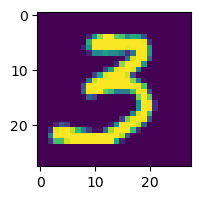

Mismatch for image 977: predicted 8, true label 6


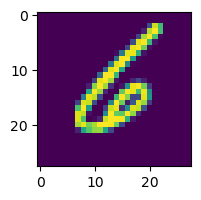

Mismatch for image 978: predicted 8, true label 1


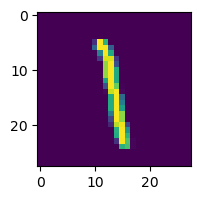

Mismatch for image 979: predicted 8, true label 0


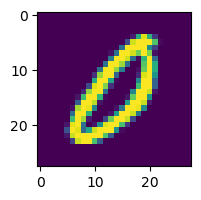

Mismatch for image 980: predicted 8, true label 9


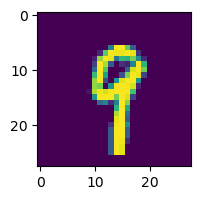

Mismatch for image 981: predicted 8, true label 7


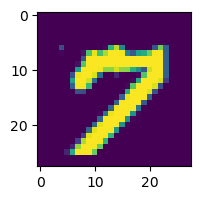

Mismatch for image 982: predicted 8, true label 1


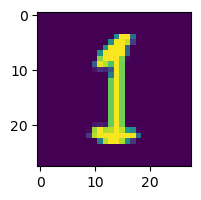

Mismatch for image 983: predicted 8, true label 3


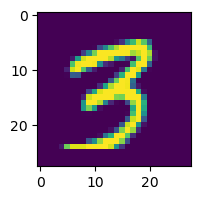

Mismatch for image 984: predicted 8, true label 0


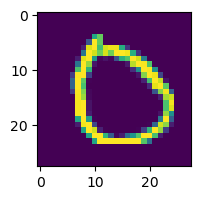

Mismatch for image 985: predicted 8, true label 5


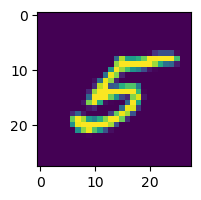

Mismatch for image 986: predicted 8, true label 6


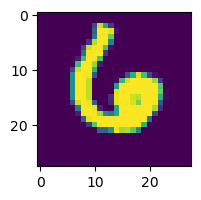

Mismatch for image 987: predicted 8, true label 4


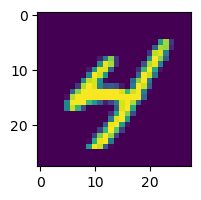

Mismatch for image 988: predicted 8, true label 4


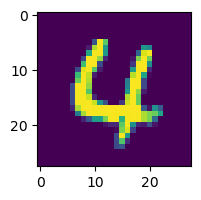

Mismatch for image 989: predicted 8, true label 2


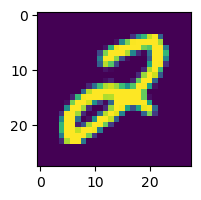

Mismatch for image 990: predicted 8, true label 4


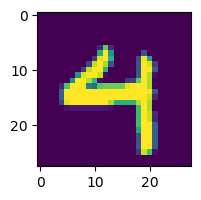

Mismatch for image 991: predicted 8, true label 4


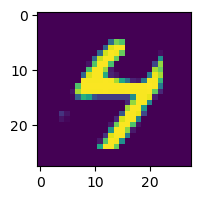

Mismatch for image 992: predicted 8, true label 3


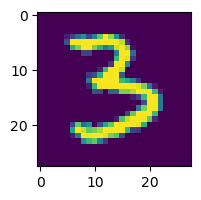

Mismatch for image 993: predicted 8, true label 1


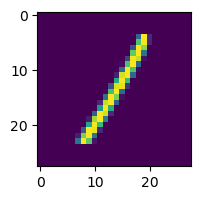

Mismatch for image 994: predicted 8, true label 7


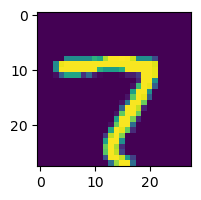

Mismatch for image 995: predicted 8, true label 7


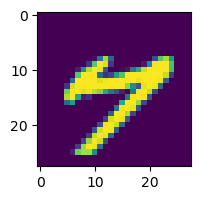

Mismatch for image 996: predicted 8, true label 6


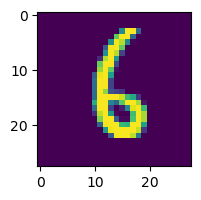

Mismatch for image 997: predicted 8, true label 0


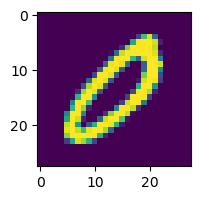

Mismatch for image 998: predicted 8, true label 3


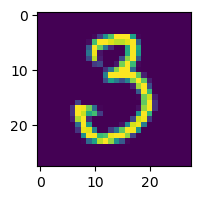

Mismatch for image 999: predicted 8, true label 6


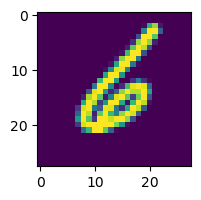

In [60]:
# Single evaluation of the model on a single image
i_s = range(1000)
for i in i_s:
    with torch.no_grad():
        image = mnist.data[i].unsqueeze(0).unsqueeze(0).float()
        output = model(image)
        output = output.argmax(dim=1).item()
        # print(f"Output for image {i}: {output}")
        # Compare the output with the true label
        true_label = mnist.targets[i].item()
        if output != true_label:
            print(f"Mismatch for image {i}: predicted {output}, true label {true_label}")

            # Show image, and make sure to display all of them
            plt.figure(figsize=(2, 2))
            img_mismatch = mnist.data[i].numpy()
            plt.imshow(img_mismatch)
            plt.show()

In [47]:
img_data = mnist.data[i].unsqueeze(0).unsqueeze(0).float()
print(f"Image pixel range: {img_data.min()} to {img_data.max()}")

Image pixel range: 0.0 to 255.0


In [55]:
cf = confusion_matrix(mnist.targets[:1000].numpy(), [model(mnist.data[i].unsqueeze(0).unsqueeze(0).float()).argmax(dim=1).item() for i in range(1000)])

In [56]:
# Visualize the confusion matrix
def plot_confusion_matrix_basic(cm, class_names=None, title="Confusion Matrix"):
    """Plot confusion matrix using matplotlib"""
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

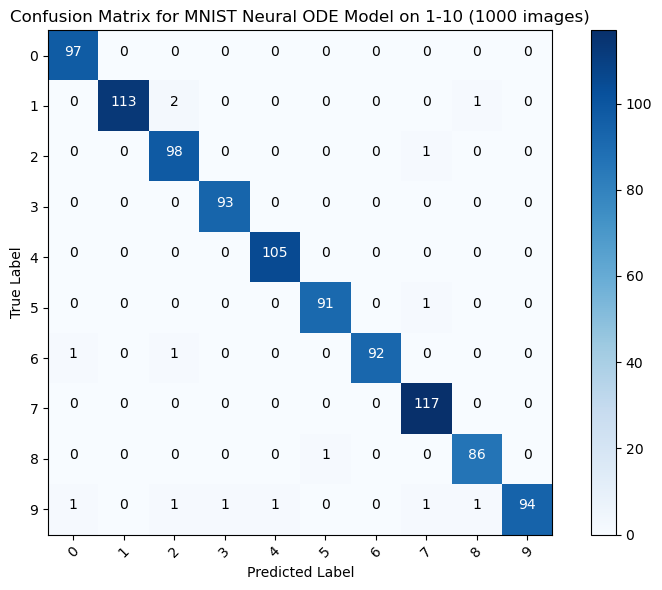

In [57]:
plot_confusion_matrix_basic(cf, class_names=[str(i) for i in range(10)], title="Confusion Matrix for MNIST Neural ODE Model on 1-10 (1000 images)")